# 1. Load libraries and data

Load libraries and set colors

In [1]:
library(phyloseq); packageVersion("phyloseq")
library(dada2)
library(ggplot2); packageVersion("ggplot2")
library(tidyr)
library(dplyr)
library(vegan); packageVersion("vegan")
library(scales)
library(repr)
library(reshape2)
library(genefilter)
library(VennDiagram)
library(svglite)
library(gridExtra)
library(DESeq2); packageVersion("DESeq2")

options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

#colorblind color vector for taxonomy plots
colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00")

set.seed(100)

[1] ‘1.24.2’

Loading required package: Rcpp


[1] ‘3.0.0’

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-2


[1] ‘2.5.2’


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: grid
Loading required package: futile.logger

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDu

[1] ‘1.20.0’

Load data and make phyloseq object

In [2]:
taxa <- readRDS("/SCIENCE/Nelson_lab/data_files_nelson/el_paso_16S/dada2_full/tax_final.rds")
seqtab.nochim <- readRDS("/SCIENCE/Nelson_lab/data_files_nelson/el_paso_16S/dada2_full/seqtab_final.rds")

# Make a data.frame holding the sample data where rownames are sampleIDs and headers are metadata parameters
metadata <- read.table("/SCIENCE/Nelson_lab/data_files_nelson/el_paso_16S/sample_data.txt", 
                       header=TRUE, row.names = 1, sep="\t")
metadata$SampleID <- row.names(metadata)
metadata$combined_name <- paste(metadata$Description, metadata$Day, sep="_")
metadata$longer_name <- paste(metadata$Location, metadata$combined_name, sep="_")

#unique(metadata$Location) #to show all locations, then set factor levels so they are ordered along treatment train
metadata$Location <- factor(metadata$Location, 
                            levels=c("WW_2ndary", "Chloramine", "MF", "NF-RO",
                                     "AOP", "Unknown", "GAC", "ESB", "SDS", 
                                     "Amplification", "Extraction", "Field", "Mock"))

# Construct phyloseq object from dada2 outputs and metadata table
ps <- phyloseq(otu_table(seqtab.nochim, taxa_are_rows=FALSE), 
               sample_data(metadata), 
               tax_table(taxa))

#exported the sequences to fasta for other analyses
#uniquesToFasta(seqtab.nochim, "/SCIENCE/Nelson_lab/data_files_nelson/el_paso_16S/dada2_full/all_seqs.fasta")

ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5336 taxa and 168 samples ]
sample_data() Sample Data:       [ 168 samples by 28 sample variables ]
tax_table()   Taxonomy Table:    [ 5336 taxa by 6 taxonomic ranks ]

In [3]:
##Sample counts before filtering
sample_count_prefiltering <- metadata %>% group_by(Type, Location) %>% summarize(sample_count=length(SampleID))
sample_count_prefiltering <- dcast(sample_count_prefiltering, Location~Type, value.var="sample_count")
sample_count_prefiltering

Location,Biofilm,Blank,Bulk,Control,Media
WW_2ndary,3,NA,6,NA,NA
Chloramine,3,NA,4,NA,NA
MF,8,NA,5,NA,NA
NF-RO,6,NA,3,NA,NA
AOP,1,NA,NA,NA,NA
Unknown,1,NA,NA,NA,NA
GAC,9,NA,15,NA,12
ESB,4,NA,NA,NA,NA
SDS,52,NA,11,NA,NA
Amplification,NA,3,NA,NA,NA


# 2. Contaminant and sample removal

In [4]:
## Remove mock controls and samples that look very weird based on previous data exploration

#remove low-biomass samples that look strongly contaminated with influent
ps_pruned <- prune_samples(sample_names(ps) != "11", ps)
ps_pruned <- prune_samples(sample_names(ps_pruned) != "68", ps_pruned) #SDS
ps_pruned <- prune_samples(sample_names(ps_pruned) != "12", ps_pruned) #NF-RO

#remove samples that look strongly contaminated with MF filtrate
#(Two sequences took over the whole library and one is the Mycobacterium from all MF samples)
ps_pruned <- prune_samples(sample_names(ps_pruned) != "69", ps_pruned) #SDS

#remove sample whose barcodes were unknown
ps_pruned <- prune_samples(sample_names(ps_pruned) != "200", ps_pruned)

#remove mock community positive controls
ps_nomock <- prune_samples(sample_names(ps_pruned) != "Mock1", ps_pruned)
ps_nomock <- prune_samples(sample_names(ps_nomock) != "Mock2", ps_nomock)

In [5]:
#save mock data for comparison to metagenomics
ps_mock <- subset_samples(ps_pruned, subset = Location %in% "Mock")
ps_mock <- filter_taxa(ps_mock, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_mock_perc <- transform_sample_counts(ps_mock, function(OTU) 100*OTU/sum(OTU))
#saveRDS(ps_mock_perc, "/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/amplicon_mock_controls.rds")

In [6]:
sample_data(ps_pruned)

,Plate,step_number,Type,Location,Description,Day,DNA_conc,is_blank,field_blank,extraction_blank,⋯,Forward_Barcode,Reverse_Barcode,reads_unfiltered,reads_filtered_DADA2,reads_nochim,percent.reads.not.chimeric,Metagenomes,SampleID,combined_name,longer_name
103,X,6,Biofilm,AOP,Treated,234,NA,n,na,104,⋯,TCGACGAG,ACCTACTG,97284,69057,66021,0.9560363,NA,103,Treated_234,AOP_Treated_234
104,X,0,Blank,Extraction,PowerBiofilm,234,NA,y,na,104,⋯,TACGAGAC,GAGCTCAT,32455,25056,25035,0.9991619,NA,104,PowerBiofilm_234,Extraction_PowerBiofilm_234
105,X,7,Biofilm,GAC,1,234,0.186,n,na,na,⋯,ACGTCTCG,GTATGACG,143531,99912,90999,0.9107915,NA,105,1_234,GAC_1_234
106,X,7,Biofilm,GAC,1,234,0.131,n,na,na,⋯,GTCAGATA,TAGACTGA,131682,97884,89644,0.9158187,NA,106,1_234,GAC_1_234
107,Y,7,Biofilm,GAC,1,234,0.0868,n,na,na,⋯,GACACTGA,AGCGCTAT,54684,40911,40911,1.0000000,NA,107,1_234,GAC_1_234
109,Y,9,Biofilm,SDS,1,184,NA,n,na,117,⋯,ATATACAC,CTAGCTCG,76189,57130,57125,0.9999125,NA,109,1_184,SDS_1_184
10,P,2,Bulk,Chloramine,Treated,184,0.388,n,16,na,⋯,ATATACAC,TCACGATG,98914,73091,73048,0.9994117,NA,10,Treated_184,Chloramine_Treated_184
110,Y,9,Biofilm,SDS,1,184,NA,n,na,117,⋯,ACGACGTG,TAGACTGA,94841,73282,71966,0.9820420,NA,110,1_184,SDS_1_184
111,Y,9,Biofilm,SDS,2,184,NA,n,na,117,⋯,TGCGTACG,AGCGCTAT,151098,109287,108821,0.9957360,NA,111,2_184,SDS_2_184
112,Y,9,Biofilm,SDS,2,184,NA,n,na,117,⋯,CGTCGCTA,AGTCTAGA,87325,64883,64875,0.9998767,NA,112,2_184,SDS_2_184


In [7]:
#run DESeq2 on all bulk and blank ASVs together
#identify ASVs significantly more prevalent in bulk
#keep ASVs present only in bulk and ASVs significantly more prevalent in bulk than blank

## Preparing for DESeq

#select only samples of interest
ps_bulk <- subset_samples(ps_nomock, subset = Type %in% c("Bulk"))
ps_blank <- subset_samples(ps_nomock, subset = Type %in% c("Blank"))

blanks_list <- c("Amplification_PlateX_na", "Amplification_PlateY_na", "Amplification_PlateP_na", 
  "Extraction_PhenolChloroform_na", "Field_NA_184", "Field_NA_206", "Field_NA_213") #blanks that apply to bulk data

ps_blank <- subset_samples(ps_blank, subset = longer_name %in% c(blanks_list))

#merge bulk and blank samples back together and filter for only taxa that occur in at least one sample
ps_bulk_blank <- merge_phyloseq(ps_bulk, ps_blank)
ps_bulk_blank <- filter_taxa(ps_bulk_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

#remove samples with too few reads
ps_bulk_blank <- prune_samples(sample_sums(ps_bulk_blank)>=10000, ps_bulk_blank) #remove failed samples

## Filter taxa occurring in bulk samples and taxa occuring in blank. 
#for later: Get bulk-only taxa and intersecting taxa.

ps_blank_occur <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_bulk_occur <- filter_taxa(ps_bulk, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

blank_taxa <- row.names(tax_table(ps_blank_occur))
bulk_taxa <- row.names(tax_table(ps_bulk_occur))
intersecting_taxa <- intersect(bulk_taxa, blank_taxa)
bulk_only_taxa <- setdiff(bulk_taxa, intersecting_taxa)
blank_only_taxa <- setdiff(blank_taxa, intersecting_taxa)

ps_bulk_only <- prune_taxa(bulk_only_taxa, ps_bulk_blank)


ps_bulk_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3033 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 28 sample variables ]
tax_table()   Taxonomy Table:    [ 3033 taxa by 6 taxonomic ranks ]

In [8]:
#run DESeq on the bulk and blank taxa

dds = phyloseq_to_deseq2(ps_bulk_blank, ~ is_blank)
dds = DESeq(dds, test="Wald", fitType="local")

#analyze results of DESeq filtering for significance
res = results(dds, cooksCutoff = FALSE)
alpha = 0.01
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps_bulk_blank)[rownames(sigtab), ], "matrix"))
sigtab
significant_taxa <- row.names(sigtab[sigtab$log2FoldChange < 0,]) #remove anything significantly enriched in blanks

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 1705 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus
CGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCACGTTGTCCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTGGAGTACTGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAG,18498.16165,-30.000000,4.107000,-7.304603,2.780874e-13,1.251010e-10,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium
CGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCGTTTTAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATGGCCTTCGATACTGGGACGCTTGAGTATGGTAGAGGTTGGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCGGTGGCGAAGGCGGCCAACTGGACCATCACTGACGCTGAGGCG,49.97704,-25.586411,3.507124,-7.295553,2.974347e-13,1.251010e-10,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Methylobacteriaceae,Methylobacterium
CGTTGCTCGGAATCACTGGGCGTAAAGGGTGCGTAGGCGGGTCTTTAAGTCAGGGGTGAAATCCTGGAGCTCAACTCCAGAACTGCCTTTGATACTGAAGATCTTGAGTTCGGGAGAGGTGAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGATACTGACGCTGAGGCA,4502.13519,-7.755159,1.904524,-4.071966,4.661795e-05,2.000766e-03,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Bradyrhizobium
CGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGATATGTAAGTTAGAAGTGAAATCCCCGGGCTCAACCTGGGAATGGCTTTTAAGACTGCGTATCTAGAGTTTGTCAGAGGGGGGTGGAATTCCAAGTGTAGCAGTGAAATGCGTAGAGATTTGGAGGAACACCAATGGCGAAGGCAACCCCCTGGGATAAAACTGACGCTCATGCA,92696.77699,-19.201345,3.554756,-5.401593,6.605156e-08,5.342555e-06,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,NA
CGTTGTTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGATTTGTAAGTCAGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTTGATACTGCGAATCTTGAGTCCGATAGAGGTGGGTGGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAAGAACACCGGTGGCGAAGGCGGCCCACTGGATCGGTACTGACGCTGAGGTG,1947.95309,-9.490015,2.351239,-4.036176,5.432950e-05,2.285099e-03,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Hyphomicrobiaceae,Hyphomicrobium
CGTTATCCGGAATCATTGGGTTTAAAGGGTCCGTAGGCGGTCTTATAAGTCAGTGGTGAAAGCCCATCGCTCAACGATGGAACTGCCATTGATACTGTAAGACTTGAATGCTTAGGAAGTAACTAGAATATGTAGTGTAGCGGTGAAATGCTTAGATATTACATGGAATACCAATTGCGAAGGCAGGTTACTACTAAGTGATTGACGCTGATGGA,750.78241,-29.294053,4.473963,-6.547674,5.843993e-11,1.365546e-08,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Flavobacterium
CGTTGTTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGATCTTTAAGTCAGGGGTGAAATCCCGAGGCTCAACCTCGGAACTGCCTTTGATACTGGAGGTCTCGAGTCCGGGAGAGGTGAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGGAACTGACGCTGAGGTG,881.63011,-29.440660,3.110445,-9.465097,2.932888e-21,6.167865e-18,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Methylocystaceae,Methylocystis
CGTTGCTCGGAATCACTGGGCGTAAAGGGTGCGTAGGCGGGTCTTTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTGCCTTTGATACTGAGGATCTCGAGTTCGGGAGAGGTGAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGATACTGACGCTGAGGCA,635.14489,-27.715746,3.359948,-8.248862,1.599103e-16,1.681457e-13,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Afipia
CGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGATATGTAAGTTAGGAGTGAAATCCCCGGGCTCAACCTGGGAATGGCTTTTAAGACTGCGTATCTAGAGTTTGTCAGAGGGGGGTGGAATTCCAAGTGTAGCAGTGAAATGCGTAGAGATTTGGAGGAACACCAATGGCGAAGGCAACCCCCTGGGATAAAACTGACGCTCATGCA,1702.70647,-30.000000,5.602484,-5.354767,8.566654e-08,5.507141e-06,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,NA
CGTTATCCGGAATCATTGGGTTTAAAGGGTCCGTAGGCGGTTGAATAAGTCAGTGGTGAAATCCGGCAGCTTAACTGTCGAACTGCCATTGATACTGTTTAACTTGAATTACTGTGAAGTAACTAGAATATGTAGTGTAGCGGTGAAATGCTTAGATATTACATGGAATACCAATTGCGAAGGCAGGTTACTAATGGTTTATTGACGCTGATGGA,2127.20758,-30.000000,5.145467,-5.830375,5.530299e-09,6.841305e-07,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Flavobacterium


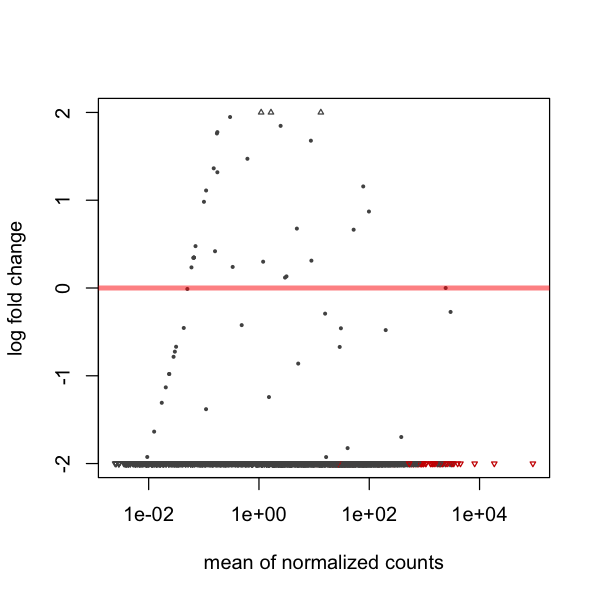

In [9]:
#plot deseq results
options(repr.plot.width = 5, repr.plot.height = 5)
plotMA(res, ylim=c(-2,2))
#plot shows that the only significantly enriched ASVs were those with negative log fold-change 
#(enriched in samples over blanks)
#none were significantly enriched in blanks over samples

In [10]:
## Identify ASVs that were in both blank and bulk and were significantly enriched in bulk
samples_over_blanks <- intersect(intersecting_taxa, significant_taxa)

sigtab[row.names(sigtab) %in% samples_over_blanks,] #what are these taxa?

## Combine to get taxa from bulk-only and taxa significant by DESeq, convert to relative abundance of remaining reads
ps_bulk_blank_sig <- prune_taxa(taxa=union(significant_taxa, bulk_only_taxa), ps_bulk_blank)
sample_data(ps_bulk_blank_sig)$filtered_readcounts <- sample_sums(ps_bulk_blank_sig)

ps_bulk_blank_sig <- prune_samples(sample_sums(ps_bulk_blank_sig)>=300, ps_bulk_blank_sig) #remove samples now with too few reads
ps_bulk_blank_sig_perc <- transform_sample_counts(ps_bulk_blank_sig, function(OTU) 100*OTU/sum(OTU))
                                                  
ps_bulk_blank_sig

ps_bulk_clean <- subset_samples(ps_bulk_blank_sig, subset= Type %in% "Bulk")
ps_bulk_clean_perc <- transform_sample_counts(ps_bulk_clean, function(OTU) 100*OTU/sum(OTU))
                                              
#saveRDS(ps_bulk_clean_perc, "/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/amplicon_data_deseq.rds")

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus
CGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCACGTTGTCCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTGGAGTACTGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAG,18498.1617,-30.000000,4.107000,-7.304603,2.780874e-13,1.251010e-10,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium
CGTTGCTCGGAATCACTGGGCGTAAAGGGTGCGTAGGCGGGTCTTTAAGTCAGGGGTGAAATCCTGGAGCTCAACTCCAGAACTGCCTTTGATACTGAAGATCTTGAGTTCGGGAGAGGTGAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGATACTGACGCTGAGGCA,4502.1352,-7.755159,1.904524,-4.071966,4.661795e-05,2.000766e-03,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Bradyrhizobium
CGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGATATGTAAGTTAGAAGTGAAATCCCCGGGCTCAACCTGGGAATGGCTTTTAAGACTGCGTATCTAGAGTTTGTCAGAGGGGGGTGGAATTCCAAGTGTAGCAGTGAAATGCGTAGAGATTTGGAGGAACACCAATGGCGAAGGCAACCCCCTGGGATAAAACTGACGCTCATGCA,92696.7770,-19.201345,3.554756,-5.401593,6.605156e-08,5.342555e-06,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,NA
CGTTGTTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGATTTGTAAGTCAGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTTGATACTGCGAATCTTGAGTCCGATAGAGGTGGGTGGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAAGAACACCGGTGGCGAAGGCGGCCCACTGGATCGGTACTGACGCTGAGGTG,1947.9531,-9.490015,2.351239,-4.036176,5.432950e-05,2.285099e-03,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Hyphomicrobiaceae,Hyphomicrobium
CGTTATCCGGAATCATTGGGTTTAAAGGGTCCGTAGGCGGTCTTATAAGTCAGTGGTGAAAGCCCATCGCTCAACGATGGAACTGCCATTGATACTGTAAGACTTGAATGCTTAGGAAGTAACTAGAATATGTAGTGTAGCGGTGAAATGCTTAGATATTACATGGAATACCAATTGCGAAGGCAGGTTACTACTAAGTGATTGACGCTGATGGA,750.7824,-29.294053,4.473963,-6.547674,5.843993e-11,1.365546e-08,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Flavobacterium
CGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGATATGTAAGTTAGGAGTGAAATCCCCGGGCTCAACCTGGGAATGGCTTTTAAGACTGCGTATCTAGAGTTTGTCAGAGGGGGGTGGAATTCCAAGTGTAGCAGTGAAATGCGTAGAGATTTGGAGGAACACCAATGGCGAAGGCAACCCCCTGGGATAAAACTGACGCTCATGCA,1702.7065,-30.000000,5.602484,-5.354767,8.566654e-08,5.507141e-06,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,NA
CGTTATCCGGAATTACTGGGCGTAAAGGGTGCGTAGGTGGTTTCTTAAGTCAGAGGTGAAAGGCTACGGCTCAACCGTAGTAAGCCTTTGAAACTGGGAAACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTTGCGAAGGCGGCTCTCTGGACTGTAACTGACACTGAGGCAC,8150.5603,-30.000000,3.674791,-8.163729,3.248365e-16,2.277104e-13,Bacteria,Firmicutes,Clostridia,Clostridiales,Peptostreptococcaceae,Romboutsia


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2900 taxa and 39 samples ]
sample_data() Sample Data:       [ 39 samples by 29 sample variables ]
tax_table()   Taxonomy Table:    [ 2900 taxa by 6 taxonomic ranks ]

In [11]:
#save sequences for metagenomics
ps_bulk_clean_perc_metagenomics <- subset_samples(ps_bulk_clean_perc, !is.na(Metagenomes))
ps_bulk_clean_perc_metagenomics
#saveRDS(ps_bulk_clean_perc_metagenomics, "/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/amplicon_data_for_metagenomes_deseq.rds")

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2900 taxa and 8 samples ]
sample_data() Sample Data:       [ 8 samples by 29 sample variables ]
tax_table()   Taxonomy Table:    [ 2900 taxa by 6 taxonomic ranks ]

**Look at how many samples we have after filtering**

In [12]:
sample_count_filtered <- as.data.frame(sample_data(ps_bulk_blank_sig)) %>% group_by(Type, Location) %>% summarize(sample_count=length(SampleID))
sample_count_filtered <- dcast(sample_count_filtered, Location~Type, value.var="sample_count")
sample_count_filtered

Location,Bulk,Blank
WW_2ndary,6,NA
Chloramine,3,NA
MF,4,NA
NF-RO,2,NA
GAC,14,NA
SDS,8,NA
Amplification,NA,1
Extraction,NA,1


In [13]:
#collect samples that have metagenomics
ps_metagenome <- subset_samples(ps_nomock, subset = SampleID %in% 
                                c("Mock1", "Mock2", "Neg1", "Neg2", "Neg3", "191a", "191b", "192", "32", "40", "61", "74", "16", "1","9","33","37","38","39","65","66","67","185a","185b","187a","187b","193", "mock1", "mock2"))
ps_metagenome <- prune_samples(sample_sums(ps_metagenome)>=750, ps_metagenome)
ps_metagenome_perc <- transform_sample_counts(ps_metagenome, function(OTU) 100*OTU/sum(OTU))

#saveRDS(ps_metagenome_perc, file="/SCIENCE/Nelson_lab/data_files_nelson/el_paso_16S/dada2_full/phyloseq_metagenomic_samples.rds")

# 3. Rarefaction curves and alpha diversity

Rarefaction curves appear to plateau (note that singletons have been removed by DADA2). Singletons arising from sequencing errors can artificially inflate counts of observed taxa but removing them could underestimate richness. Given that curves mostly plateau, counts of observed ASVs may approximate richness despite different sequencing depths.

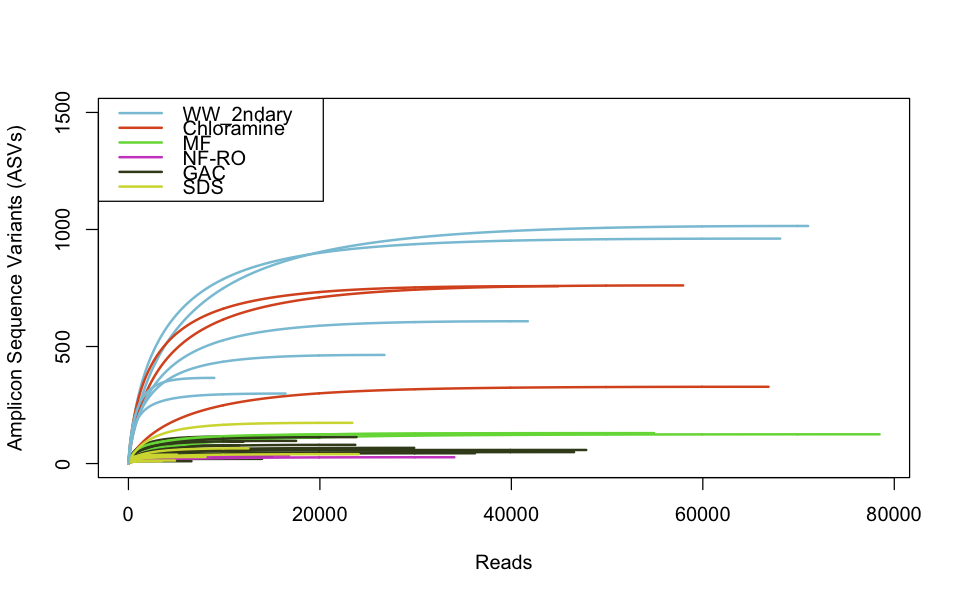

In [14]:
otu_bulk_clean <- as.data.frame(otu_table(ps_bulk_clean))

bulk_locations_colors <- c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10])
palette(c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10]))

options(repr.plot.width = 8, repr.plot.height = 5)

#pdf("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/rarecurve_bulk_nolabels.pdf", height=6, width=8)
rarecurve(otu_bulk_clean, step=100, col=sample_data(ps_bulk_blank_sig)$Location, 
          xlab="Reads", ylab="Amplicon Sequence Variants (ASVs)", lwd=2, ylim=c(0,1500), label=FALSE)

legend("topleft", legend=c("WW_2ndary", "Chloramine", "MF", "NF-RO", "GAC", "SDS"), 
       col=bulk_locations_colors, 
       lty=1, lwd=2)
#dev.off() #uncomment to save figure

In [15]:
#count observed ASVs in bulk water samples and associated blanks

min(rowSums(otu_table(ps_bulk_clean))) #3499 (Amplification = 787 reads, Extraction = 350)
max(rowSums(otu_table(ps_bulk_clean))) #78462 reads
                             
metadata_bulk <- as.data.frame(sample_data(ps_bulk_blank_sig))
metadata_bulk <- cbind(metadata_bulk, estimate_richness(ps_bulk_blank_sig, measures="Observed"))
metadata_bulk %>% 
    select(Location, Observed) %>% 
    group_by(Location) %>% 
    summarize(min(Observed), max(Observed), mean(Observed), median(Observed))

#calculate log-fold change in observed ASVs between WW_2ndary and NF/RO perm
log10(49.75000/618.83333)#based on mean, ww2ndary vs SDS

[1] 3499

[1] 78462

Warning message in estimate_richness(ps_bulk_blank_sig, measures = "Observed"):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”

Location,min(Observed),max(Observed),mean(Observed),median(Observed)
WW_2ndary,299,1015,618.83333,536.0
Chloramine,328,761,615.66667,758.0
MF,110,130,123.00000,126.0
NF-RO,27,34,30.50000,30.5
GAC,10,116,65.78571,65.0
SDS,10,174,49.75000,34.0
Amplification,2,2,2.00000,2.0
Extraction,3,3,3.00000,3.0


[1] -1.094781

**Note: alpha diversity functions produce a warning about singletons having already been removed. This is because many alpha diversity calculations rely on singletons despite the fact that they may be due to sequencing errors. Singletons were removed as part of the DADA2 workflow. We proceed anyway, after reviewing rarefaction curves.**

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”

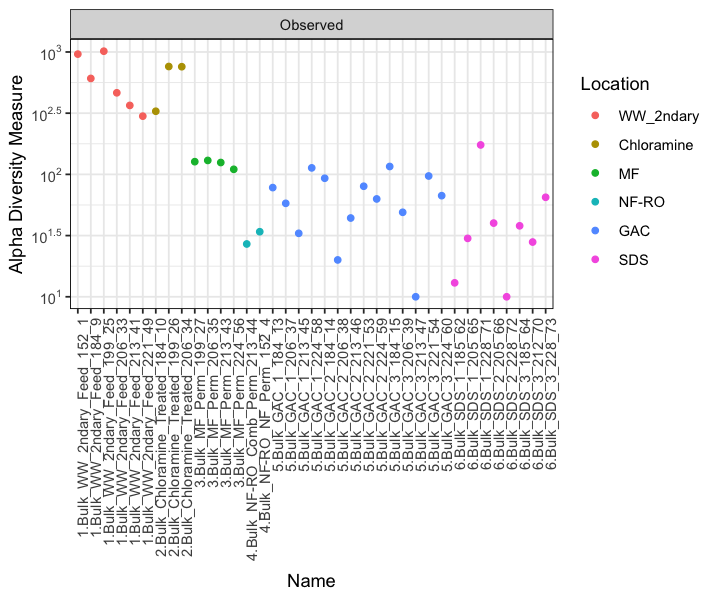

In [16]:
options(repr.plot.width = 6, repr.plot.height = 5) #for plotting size in jupyter

plot_richness(ps_bulk_clean, x="Name", measures="Observed", color="Location") +
theme_bw() +
scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA), 
      axis.text.x = element_text(angle = 90, hjust = 1))
#ggsave("/SCIENCE/Nelson_lab/data_files_nelson/el_paso_16S/figures_dada2/alpha_diversity_observed_seqs.pdf", device="pdf", width=16, height=10)

**Plot alpha diversity as observed ASVs (Figure 2B)**

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”

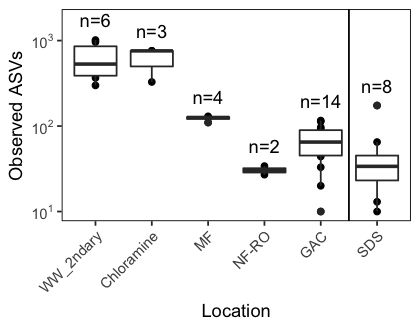

In [17]:
#define function to put sample count above data
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
#ps_bulk_sig <- subset_samples(ps_bulk_blank_sig, subset = Type %in% "Bulk")
options(repr.plot.width = 3.5, repr.plot.height = 2.75)
plot_richness(ps_bulk_clean, x="Location", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
     strip.text.x = element_blank(),
     #axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    ylab("Observed ASVs") +
    scale_y_continuous(trans="log10", limits=c(10,1800), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1)+
    geom_vline(xintercept=5.5, linetype='solid')

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/asv_observed_boxplot.svg", device="svg", width=3.5, height=2.75)

**Plot flow cytometry cell counts for comparison to alpha diversity  (Figure 2A)**

Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”

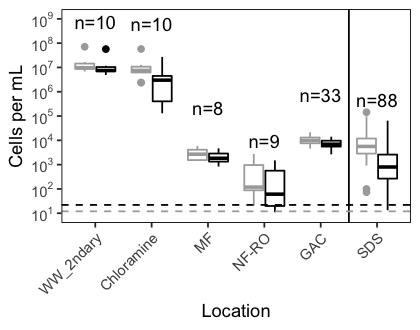

In [18]:
#load FCM data
fcm_all <- read.table("/SCIENCE/Nelson_lab/data_files_nelson/el_paso_fcm/elpaso_fcm_all_071918.tsv", header=TRUE, sep="\t")
fcm_all <- fcm_all[, c("Location", "TCC_avg_cells_per_mL", "ICC_avg_cells_per_mL")]
fcm_all <- subset(fcm_all, fcm_all$Location %in% c('WW_2ndary', 'Chloramine', 'MF_combined', 'NF-RO_combined', 'GAC', 'SDS'))
fcm_all$Location <- factor(fcm_all$Location, levels=c('WW_2ndary', 'Ozone', 'Chloramine', 'MF_combined', 'NF-RO_combined', 'GAC', 'SDS'))
fcm_all_melt <- melt(fcm_all, id.vars = c("Location"), value.name = "Cells_per_mL", variable.name = "Assay")
n_fun <- function(x){return(data.frame(y = median(x), label = paste0("n=",length(x))))}

#make plot
options(repr.plot.width = 3.5, repr.plot.height = 2.75)
ggplot(fcm_all_melt, aes(x=Location, y=Cells_per_mL, color=Assay))+
    geom_boxplot()+
    scale_color_manual(values=c("darkgray", "black"))+
    #add sample size (just show for TCC bc it's the same for ICC)
    stat_summary(data = subset(fcm_all_melt, fcm_all_melt$Assay %in% c("TCC_avg_cells_per_mL")),
       fun.data = n_fun, geom = "text", vjust=-3, color='black')+
    scale_y_continuous(trans="log", 
                       breaks=c(10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000), 
                       labels=trans_format("log10", math_format(10^.x)),
                       limits=c(10,1000000000))+
    ylab("Cells per mL") +
    scale_x_discrete(labels= c('WW_2ndary', 'Chloramine', 'MF', 'NF-RO', 'GAC', 'SDS')) +
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
         #axis.text.x = element_blank(), 
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), 
        #axis.title.x = element_blank(),
         legend.position="none")+
    geom_vline(xintercept=5.5, linetype='solid')+
    geom_hline(yintercept=12, linetype='dashed', color="darkgray")+
    geom_hline(yintercept=22, linetype='dashed', color="black")

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/fcm_boxplot.svg", device="svg", width=3.5, height=2.75)

In [19]:
fcm_all %>% group_by(Location) %>% na.omit() %>% summarize(median(ICC_avg_cells_per_mL))
#metadata %>% group_by(Type, Location) %>% summarize(sample_count=length(SampleID))
log10(6933/760)

Location,median(ICC_avg_cells_per_mL)
WW_2ndary,7495000
Chloramine,3010666
MF_combined,1853
NF-RO_combined,22
GAC,6933
SDS,760


[1] 0.9601076

# 4. Taxonomic composition

Warning message:
“Transformation introduced infinite values in discrete y-axis”

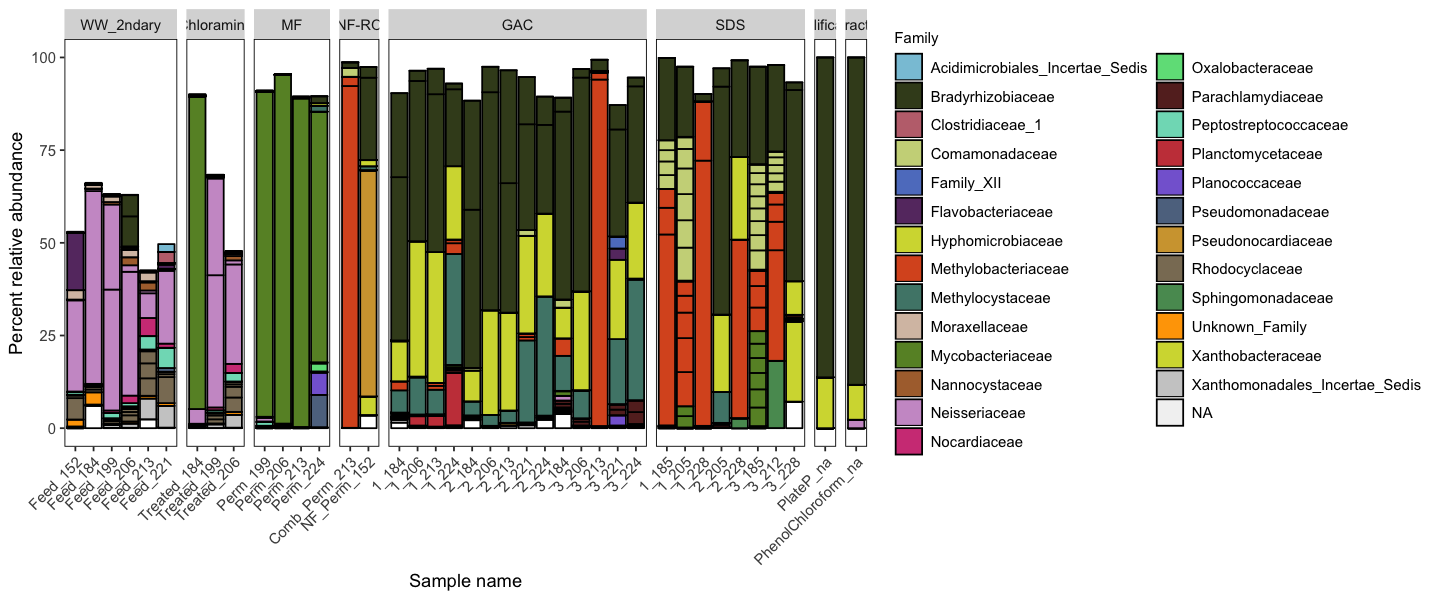

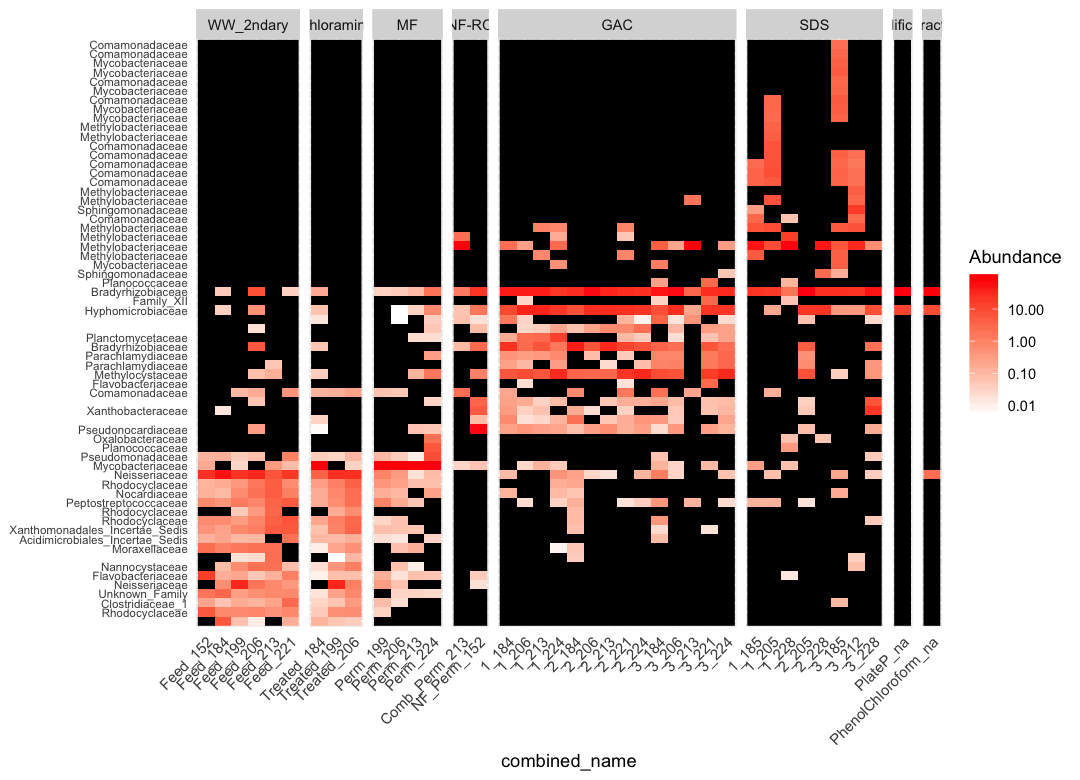

In [20]:
## Plot bar and heatmap
ps_bulk_blank_sig_perc_filt2 <- filter_taxa(ps_bulk_blank_sig_perc, filterfun(kOverA(1, 2)), TRUE) #one sample, 2 perc.
options(repr.plot.width = 12, repr.plot.height = 5)
#playing with the colors a bit:
colors2 <- colors[-c(2,3,4)]
colors2[8] <- colors[2]

plot_bar(ps_bulk_blank_sig_perc_filt2, x="combined_name", fill="Family") + scale_fill_manual(values = colors2) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~Location, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/tax_barplot_min2perc.pdf", device="pdf", width=12, height=6)
                                                                                                 
options(repr.plot.width = 9, repr.plot.height = 6.5)
plot_heatmap(ps_bulk_blank_sig_perc_filt2, taxa.label = "Family", sample.label = "combined_name", sample.order = "Name", method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Location, scale="free_x", space="free_x")

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/tax_heatmap_min2perc.pdf", device="pdf", width=8, height=6.5)

In [21]:
ps_bulk_blank_sig_perc_filt2
tax_table(ps_bulk_blank_sig_perc_filt2) #get names for Family_XII and Unknown_Family in above figure

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 64 taxa and 39 samples ]
sample_data() Sample Data:       [ 39 samples by 29 sample variables ]
tax_table()   Taxonomy Table:    [ 64 taxa by 6 taxonomic ranks ]

,Kingdom,Phylum,Class,Order,Family,Genus
CGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCACGTTGTCCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTGGAGTACTGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAG,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium
CGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCGTTTTAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATGGCCTTCGATACTGGGACGCTTGAGTATGGTAGAGGTTGGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCGGTGGCGAAGGCGGCCAACTGGACCATCACTGACGCTGAGGCG,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Methylobacteriaceae,Methylobacterium
CGTTGCTCGGAATCACTGGGCGTAAAGGGTGCGTAGGCGGGTCTTTAAGTCAGGGGTGAAATCCTGGAGCTCAACTCCAGAACTGCCTTTGATACTGAAGATCTTGAGTTCGGGAGAGGTGAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGATACTGACGCTGAGGCA,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Bradyrhizobium
CGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGATATGTAAGTTAGAAGTGAAATCCCCGGGCTCAACCTGGGAATGGCTTTTAAGACTGCGTATCTAGAGTTTGTCAGAGGGGGGTGGAATTCCAAGTGTAGCAGTGAAATGCGTAGAGATTTGGAGGAACACCAATGGCGAAGGCAACCCCCTGGGATAAAACTGACGCTCATGCA,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,NA
CGTTGTTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGATTTGTAAGTCAGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTTGATACTGCGAATCTTGAGTCCGATAGAGGTGGGTGGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAAGAACACCGGTGGCGAAGGCGGCCCACTGGATCGGTACTGACGCTGAGGTG,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Hyphomicrobiaceae,Hyphomicrobium
CGTTATCCGGAATCATTGGGTTTAAAGGGTCCGTAGGCGGTCTTATAAGTCAGTGGTGAAAGCCCATCGCTCAACGATGGAACTGCCATTGATACTGTAAGACTTGAATGCTTAGGAAGTAACTAGAATATGTAGTGTAGCGGTGAAATGCTTAGATATTACATGGAATACCAATTGCGAAGGCAGGTTACTACTAAGTGATTGACGCTGATGGA,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Flavobacterium
CGTTGTTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGATCTTTAAGTCAGGGGTGAAATCCCGAGGCTCAACCTCGGAACTGCCTTTGATACTGGAGGTCTCGAGTCCGGGAGAGGTGAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGGAACTGACGCTGAGGTG,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Methylocystaceae,Methylocystis
CGTTGCTCGGAATCACTGGGCGTAAAGGGTGCGTAGGCGGGTCTTTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTGCCTTTGATACTGAGGATCTCGAGTTCGGGAGAGGTGAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGATACTGACGCTGAGGCA,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Afipia
CGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTCTGTCGCGTCGGTCGTGAAAACCTGCAGCTTAACTGTGGGCTTGCGGTCGATACGGGCATGACTGGAGTTCGGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCCGATACTGACGCTGAGGA,Bacteria,Actinobacteria,Actinobacteria,Pseudonocardiales,Pseudonocardiaceae,Pseudonocardia
CGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGATATGTAAGTTAGGAGTGAAATCCCCGGGCTCAACCTGGGAATGGCTTTTAAGACTGCGTATCTAGAGTTTGTCAGAGGGGGGTGGAATTCCAAGTGTAGCAGTGAAATGCGTAGAGATTTGGAGGAACACCAATGGCGAAGGCAACCCCCTGGGATAAAACTGACGCTCATGCA,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,NA


In [22]:
#relative abundance of Neisseriaceae in WW_2ndary (plant feed)
bulk_neisseriaceae <- subset_taxa(ps_bulk_blank_sig_perc, Family=="Neisseriaceae")
bulk_neisseriaceae <- subset_samples(bulk_neisseriaceae, subset=Location %in% "WW_2ndary")
rowSums(otu_table(bulk_neisseriaceae))

1        25        33        41        49         9 
26.007697 57.109051 36.422776  8.879964 21.438147 54.022245

In [23]:
##making supplementary table with same data as heatmap plus more
#get otu table and taxonomy table
ps_bulk_blank_sig_perc_filt1 <- filter_taxa(ps_bulk_blank_sig_perc, filterfun(kOverA(1, 1)), TRUE) #one sample, 2 perc.

otu.tab <- as.data.frame(otu_table(ps_bulk_blank_sig_perc_filt1))
tax.tab <- as.data.frame(tax_table(ps_bulk_blank_sig_perc_filt1))

#add sample names to otu table
sample_names <- subset(sample_data(ps_bulk_blank_sig_perc_filt1), select = c("longer_name"))
otu.tab <- merge(sample_names, otu.tab, all.y = TRUE, by=0)
row.names(otu.tab) <- otu.tab$longer_name
otu.tab <- t(subset(otu.tab, select = c(-Row.names, -longer_name)))
otu.tab <- as.data.frame(otu.tab) #convert back from matrix to df

#add taxonomy to otu table
otu.tab <- merge(tax.tab, otu.tab, by=0)
row.names(otu.tab) <- otu.tab$Row.names
otu.tab <- subset(otu.tab, select = -Row.names)

head(otu.tab)
#write.table(otu.tab, '/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/otu_tab_min1perc.tsv', sep='\t', quote=FALSE)

,Kingdom,Phylum,Class,Order,Family,Genus,WW_2ndary_Feed_152,Chloramine_Treated_184,GAC_1_184,GAC_2_184,⋯,SDS_1_185,SDS_3_185,SDS_1_205,SDS_2_205,SDS_3_212,SDS_1_228,SDS_2_228,SDS_3_228,WW_2ndary_Feed_184,Amplification_PlateP_na
CATTAATCGGATTTATTGGGCGTAAAGGGCGCGTAGGCGGGAAAGTCAGTCAGATGTGAAAGCCCAGGGCTCAACCCTGGAACAGCATTTGAAACTACTTTTCTAGAGGGTAGGCGGAGAAAACAGAATTCCACGTGTAGCGGTGAAATGCGTAGATATGTGGAGGAATACCGGTGGCGAAGGCAGTTTTCTAGCTTATTCCTGACGCTAATGCG,Bacteria,Chlamydiae,Chlamydiae,Chlamydiales,Parachlamydiaceae,Candidatus_Protochlamydia,0.0000000,0.00000000,0.2672183,0.00000000,⋯,0,0,0,0.6692995,0,0,0,0.42295108,0.0000000,0
CATTAATCGGATTTATTGGGCGTAAAGGGCGCGTAGGCGGGAAAGTCAGTCAGATGTGAAAGCCCAGGGCTCAACCCTGGAACAGCATTTGAAACTACTTTTCTAGAGGGTAGGCGGAGAAAACAGAATTCCACGTGTAGCGGTGAAATGCGTAGATATGTGGAGGAATACCGGTGGCGAAGGCGGTTTTCTAGCTTATTCCTGACGCTAATGCG,Bacteria,Chlamydiae,Chlamydiae,Chlamydiales,Parachlamydiaceae,Candidatus_Protochlamydia,0.0000000,0.00000000,0.4827170,0.00000000,⋯,0,0,0,0.5196425,0,0,0,0.00000000,0.0000000,0
CGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGTTAAGTCGGATGTGAAATCCCTGGGCTCAACCTAGGCACTGCATCCGATACTGGCTAACTAGAGTGTGGGAGAGGAAGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGATGGCGAAGGCAGCCTTCTGGCCTAACACTGACGCTGAGGTG,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,NA,2.5471532,0.01046901,0.0000000,0.04999167,⋯,0,0,0,0.0000000,0,0,0,0.00000000,1.0163479,0
CGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGTTAAGTCGGATGTGAAATCCCTGGGCTCAACCTAGGCACTGCATCCGATACTGGCTGACTAGAGTGTGGGAGAGGAAGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGATGGCGAAGGCAGCCTTCTGGCCTAACACTGACGCTGAGGTG,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Fluviicoccus,1.0179799,0.00000000,0.0000000,0.00000000,⋯,0,0,0,0.0000000,0,0,0,0.00000000,0.6567908,0
CGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTG,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,0.1160468,0.04337162,0.0000000,0.00000000,⋯,0,0,0,0.0000000,0,0,0,0.04788125,0.1390287,0
CGTTAATCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGTTGGCTAAGTCAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTGATACTGGCTGGCTAGAATGTGGTAGAGGGAGGCGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAATGGCGAAGGCAGCCTCCTGGGCCAACATTGACGCTGAGACG,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadales_Incertae_Sedis,Plasticicumulans,0.4685939,0.06580522,0.0000000,0.06665556,⋯,0,0,0,0.0000000,0,0,0,0.00000000,0.2492929,0


**NF-RO vs. blank:**

Warning message in metaMDS(veganifyOTU(physeq), distance, ...):
“stress is (nearly) zero: you may have insufficient data”Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”Warning message:
“Transformation introduced infinite values in discrete y-axis”

Warning message:
“Transformation introduced infinite values in discrete y-axis”

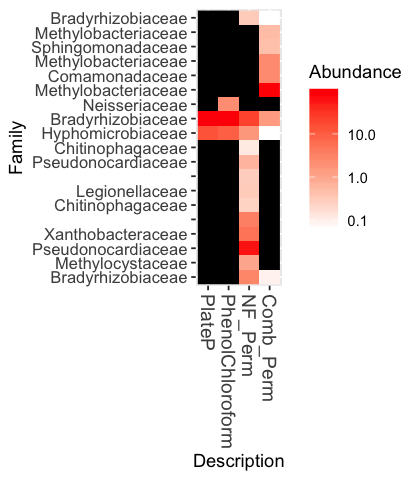

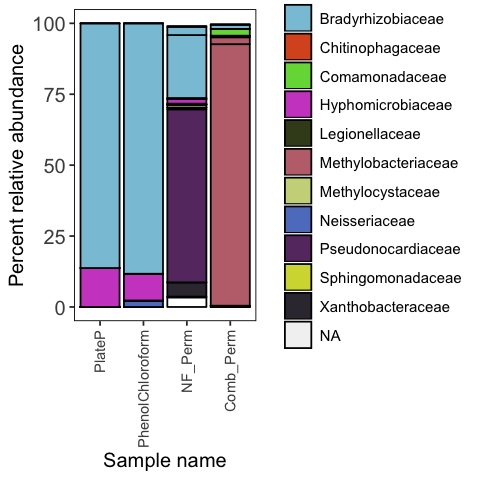

In [24]:
#subset blank and bulk, then NF-RO and amplification blank (only one remains after filtering)
ps_NFRO_blank_perc <- subset_samples(ps_bulk_blank_sig_perc, subset = Location %in% c("NF-RO", "Amplification", "Extraction")) #subset just that location

ps_NFRO_blank_perc <- filter_taxa(ps_NFRO_blank_perc, filterfun(kOverA(1, 0)), TRUE) #keep only ASVs that had reads in bulk/blanks
                                  
ps_NF_RO_filt <- filter_taxa(ps_NFRO_blank_perc, filterfun(kOverA(1, 0.1)), TRUE) #filter for ASVs > 5% relative abundance

sample_data(ps_NF_RO_filt)$Description <- factor(sample_data(ps_NF_RO_filt)$Description, 
                                                 levels=c('PlateP', 'PhenolChloroform','NF_Perm', 'Comb_Perm'))

options(repr.plot.width = 3.5, repr.plot.height = 4)
plot_heatmap(ps_NF_RO_filt, taxa.label = "Family", sample.label = "Description", 
             sample.order = c('Neg1', '61','4', '44'), 
             low="white", high="red", na.value="black", trans = log_trans(10))

ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/NF-RO_heatmap_min0.1perc.png", device="png", width=3.5, height=4)

options(repr.plot.width = 4, repr.plot.height = 4)
plot_bar(ps_NF_RO_filt, x="Description", fill="Family") + scale_fill_manual(values = colors) + 
    ylab("Percent relative abundance") +
    xlab("Sample name")+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5), 
          axis.text.y = element_text(size=12),
          axis.title=element_text(size=12),
          legend.text=element_text(size=9), 
          legend.title=element_text(size=9))
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/NF-RO_barplot_min0.1perc.png", device="png", width=4, height=4)

In [25]:
#make readable OTU table to get relative abundance values directly
NF_RO_otus <- as.data.frame(otu_table(ps_NF_RO_filt))
NF_RO_otus <- as.data.frame(t(NF_RO_otus))
NF_RO_taxa <- as.data.frame(tax_table(ps_NF_RO_filt) [, "Family"])
NF_RO_seq_info <- merge(NF_RO_otus, NF_RO_taxa, by=0)

colnames(NF_RO_seq_info) <- c("sequence", "NF-RO combined", "NF perm", "PhenolChloroform", "Amplification", "Family")
NF_RO_seq_info

sequence,NF-RO combined,NF perm,PhenolChloroform,Amplification,Family
CGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGATATGTAAGTTAGAAGTGAAATCCCCGGGCTCAACCTGGGAATGGCTTTTAAGACTGCGTATCTAGAGTTTGTCAGAGGGGGGTGGAATTCCAAGTGTAGCAGTGAAATGCGTAGAGATTTGGAGGAACACCAATGGCGAAGGCAACCCCCTGGGATAAAACTGACGCTCATGCA,0.00000000,0.0000000,2.285714,0.000,Neisseriaceae
CGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTTGTAAGACAGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTTTGTGACTGCAAGGCTGGAGTGCGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGCACTGACGCTCATGCA,2.39130435,0.0000000,0.000000,0.000,Comamonadaceae
CGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTGATTAAGTTATCTGTGAAATCCCTGGGCTTAACCTGGGCAGGTCAGATGATACTGGTTGACTCGAGTATGGGAGAGGGTAGTGGAATTTCCGGTGTAGCGGTGAAATGCGTAGAGATCGGAAGGAACACCAGTGGCGAAGGCGGCTACCTGGCCTAATACTGACACTGAGGCA,0.00000000,0.3218500,0.000000,0.000,Legionellaceae
CGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGGCATGTAAGTCAGTGGTGAAATCTTTGGGCTTAACCCGAAAACTGCCATTGATACTATATGTCTTGAATATTGTGGAGGTTAGCGGAATATGTCATGTAGCGGTGAAATGCTTAGATATGACATAGAACACCAATTGCGAAGGCAGCTGGCTACACATATATTGACGCTGAGGCA,0.00000000,0.1192037,0.000000,0.000,Chitinophagaceae
CGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGGCTGTTAAGTCAGTGGTGAAATCTTTGGGCTTAACCCGAAAACTGCCATTGATACTATCAGTCTTGAATATTGTGGAGGTCTGCGGAATATGTCATGTAGCGGTGAAATGCTTAGATATGACATAGAACACCAATTGCGAAGGCAGCAGGCTACGCATATATTGACGCTGAGGCA,0.00000000,0.2384074,0.000000,0.000,Chitinophagaceae
CGTTGCTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGGTCGTTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTGCCTTTGATACTGGCGACCTCGAGTTCGAGAGAGGTTGGTGGAACTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCCAACTGGCTCGATACTGACGCTGAGGTG,0.00000000,5.0065562,0.000000,0.000,Xanthobacteraceae
CGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCGTTTTAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATGGCCTTCGATACTGGGACGCTTGAGTATGGTAGAGGTTGGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCGGTGGCGAAGGCGGCCAACTGGACCATCACTGACGCTGAGGCG,92.19447709,0.0000000,0.000000,0.000,Methylobacteriaceae
CGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCGTTTTAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATGGCCTTCGATACTGGGACGCTTGAGTCTGGTAGAGGTTGGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCGGTGGCGAAGGCGGCCAACTGGACCGGCACTGACGCTGAGGCG,2.43243243,0.0000000,0.000000,0.000,Methylobacteriaceae
CGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCGTTTTAAGTCGTGGGTGAAAGCCTGTGGCTCAACCACAGAATGGCCTTCGATACTGGGACGCTTGAGTATGGTAGAGGTTGGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCGGTGGCGAAGGCGGCCAACTGGACCATCACTGACGCTGAGGCG,0.50528790,0.0000000,0.000000,0.000,Methylobacteriaceae
CGTTGCTCGGAATCACTGGGCGTAAAGGGTGCGTAGGCGGGTCTTTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTGCCTTTGATACTGAGGATCTCGAGTTCGGGAGAGGTGAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGATACTGACGCTGAGGCA,0.09106933,2.8906902,0.000000,0.000,Bradyrhizobiaceae


# 5. Beta diversity

In [26]:
#Bray-Curtis distance in permanova
#based on DIY public restrooms tutorial: http://joey711.github.io/phyloseq-demo/Restroom-Biogeography.html

#Normalized by percent
bulk_sample_info = as((sample_data(ps_bulk_clean_perc)), "data.frame")
bulk_bray_perc = phyloseq::distance(ps_bulk_clean_perc, "bray")
bulk_adonis = adonis(bulk_bray_perc ~ Location + Day , bulk_sample_info)
bulk_adonis

#rarefied
bulk_sample_info = as((sample_data(ps_bulk_clean_perc)), "data.frame")
ps_bulk_clean_rare <- rarefy_even_depth(ps_bulk_clean)
bulk_bray_rare = phyloseq::distance(ps_bulk_clean_rare, "bray")
bulk_adonis_rare = adonis(bulk_bray_rare ~ Location + Day , bulk_sample_info)
bulk_adonis_rare

##CLR-transformed Euclidean distance (Aitchison distance) 
##Suggested in Gloor et al 2017: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5695134/
library(microbiome)
ps_bulk_clr <- microbiome::transform(ps_bulk_clean, transform='clr')
bulk_sample_info = as(sample_data(ps_bulk_clr), "data.frame")
bulk_eucl = phyloseq::distance(ps_bulk_clr, "euclidean")
bulk_adonis_clr = adonis(bulk_eucl ~ Location + Day, bulk_sample_info)
bulk_adonis_clr


Call:
adonis(formula = bulk_bray_perc ~ Location + Day, data = bulk_sample_info) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Location   5    7.3151 1.46301  9.2221 0.57493  0.001 ***
Day        9    1.9182 0.21313  1.3435 0.15076  0.090 .  
Residuals 22    3.4901 0.15864         0.27431           
Total     36   12.7234                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`

...
962OTUs were removed because they are no longer 
present in any sample after random subsampling

...



Call:
adonis(formula = bulk_bray_rare ~ Location + Day, data = bulk_sample_info) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Location   5    7.2847 1.45694  9.0377 0.57038  0.001 ***
Day        9    1.9404 0.21560  1.3374 0.15193  0.098 .  
Residuals 22    3.5466 0.16121         0.27769           
Total     36   12.7717                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2018 Leo Lahti, Sudarshan Shetty et al. <microbiome.github.io>


Attaching package: ‘microbiome’

The following object is masked from ‘package:SummarizedExperiment’:

    coverage

The following object is masked from ‘package:GenomicRanges’:

    coverage

The following objects are masked from ‘package:IRanges’:

    coverage, transform

The following object is masked from ‘package:S4Vectors’:

    transform

The following object is masked from ‘package:base’:

    transform




Call:
adonis(formula = bulk_eucl ~ Location + Day, data = bulk_sample_info) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Location   5     21626  4325.2  5.2643 0.43627  0.001 ***
Day        9      9869  1096.6  1.3347 0.19910  0.090 .  
Residuals 22     18075   821.6         0.36464           
Total     36     49570                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [27]:
beta <- betadisper(bulk_bray_perc, bulk_sample_info$Location)
permutest(beta, permutations = 10000)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 10000

Response: Distances
          Df  Sum Sq  Mean Sq      F N.Perm  Pr(>F)  
Groups     5 0.37350 0.074700 2.6871  10000 0.05519 .
Residuals 31 0.86177 0.027799                        
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

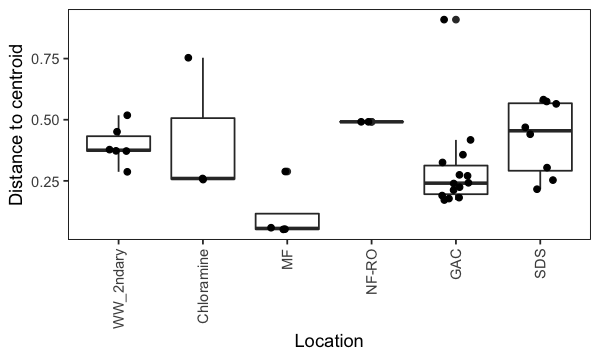

In [28]:
betadisper_distances <- as.data.frame(beta$distances)
colnames(betadisper_distances) <- c('distance_to_centroid')
betadisper_distances <- merge(betadisper_distances, bulk_sample_info, by = 0)

options(repr.plot.width = 5, repr.plot.height = 3) #for plotting size in jupyter
ggplot(betadisper_distances, aes(x=Location, y=distance_to_centroid))+
    geom_boxplot()+
    geom_jitter(position=position_jitter(0.2))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA), axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5))+
    ylab('Distance to centroid')

ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/beta_dispersion.pdf", device="pdf", width=5, height=3)

In [29]:
bulk.nmds.bray <- ordinate(ps_bulk_clean_perc, method="NMDS", distance="bray")

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1430745 
Run 1 stress 0.1497957 
Run 2 stress 0.1571088 
Run 3 stress 0.1446276 
Run 4 stress 0.147733 
Run 5 stress 0.1430027 
... New best solution
... Procrustes: rmse 0.00267851  max resid 0.01171683 
Run 6 stress 0.1609016 
Run 7 stress 0.1372294 
... New best solution
... Procrustes: rmse 0.08270109  max resid 0.2428147 
Run 8 stress 0.1363555 
... New best solution
... Procrustes: rmse 0.07672686  max resid 0.4364245 
Run 9 stress 0.1363553 
... New best solution
... Procrustes: rmse 0.000212737  max resid 0.00106038 
... Similar to previous best
Run 10 stress 0.1372294 
Run 11 stress 0.1372294 
Run 12 stress 0.1364798 
... Procrustes: rmse 0.01880287  max resid 0.09116619 
Run 13 stress 0.1431415 
Run 14 stress 0.1461884 
Run 15 stress 0.14424 
Run 16 stress 0.1337662 
... New best solution
... Procrustes: rmse 0.0428591  max resid 0.2413135 
Run 17 stress 0.1430026 
Run 18 stress 0.1500599 
Run 19 stres

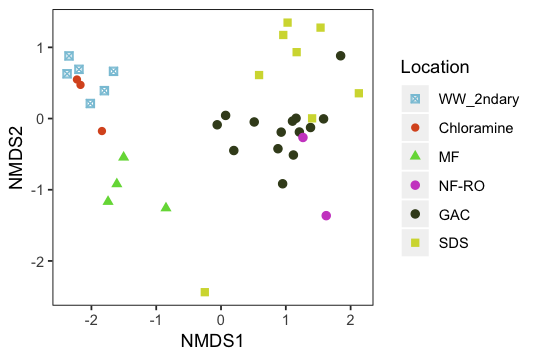

In [30]:
#FIGURE 4
options(repr.plot.width = 4.5, repr.plot.height = 3) #for plotting size in jupyter
plot_ordination(ps_bulk_clean_perc, bulk.nmds.bray, color="Location", shape="Location") + 
    geom_point(size=2)+
    scale_shape_manual(values=c(7,16,17,19,19,15, 0))+ #values=c(7,16,17,19,19,15, 0, 1)
    scale_color_manual(values = c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11]))+ #, colors[12]
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))

In [31]:
bulk.nmds.bray


Call:
metaMDS(comm = veganifyOTU(physeq), distance = distance) 

global Multidimensional Scaling using monoMDS

Data:     wisconsin(sqrt(veganifyOTU(physeq))) 
Distance: bray 

Dimensions: 2 
Stress:     0.1337662 
Stress type 1, weak ties
No convergent solutions - best solution after 20 tries
Scaling: centring, PC rotation, halfchange scaling 
Species: expanded scores based on ‘wisconsin(sqrt(veganifyOTU(physeq)))’ 


Checking the stress-plot will tell us how well the NMDS coordinates ("ordination distances") relate to the actual dissimilarities between samples ("observed dissimilarity") as determined by Bray-Curtis dissimilarity.

See: https://mb3is.megx.net/gustame/dissimilarity-based-methods/nmds

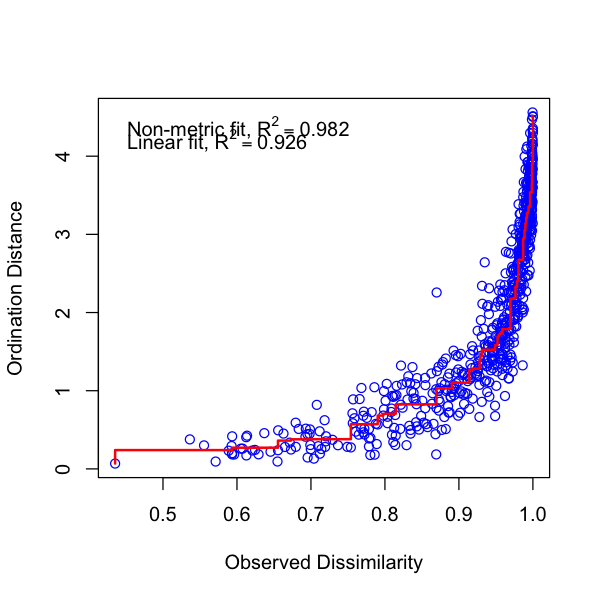

In [32]:
options(repr.plot.width = 5, repr.plot.height = 5) #for plotting size in jupyter

stressplot(bulk.nmds.bray)

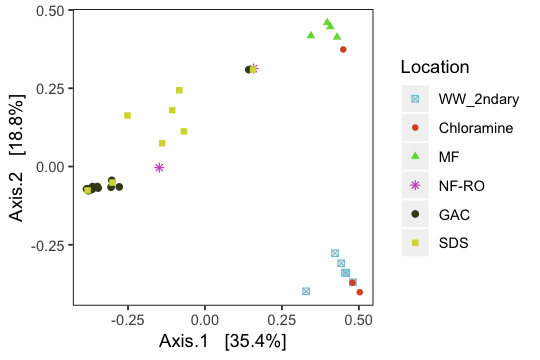

In [33]:
bulk.pcoa.bray <- ordinate(ps_bulk_clean_perc, method="PCoA", distance="bray")
options(repr.plot.width = 4.5, repr.plot.height = 3) #for plotting size in jupyter
plot_ordination(ps_bulk_clean_perc, bulk.pcoa.bray, color="Location", shape="Location") + 
    scale_shape_manual(values=c(7,16,17,8,19,15))+
    scale_color_manual(values = c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11], colors[12]))+
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/beta_diversity_BC_PCoA_bulk.pdf", device="pdf", width=4.5, height=3)
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/beta_diversity_BC_PCoA_bulk.svg", device="svg", width=4.5, height=3)

ANOSIM of bulk locations

In [34]:
location_group = get_variable(ps_bulk_clean_perc, "Location")
location_ano = anosim(phyloseq::distance(ps_bulk_clean_perc, "bray"), location_group) 
#had to specify phyloseq here because there is another "distance" method in another package that's running
location_ano$signif
location_ano$statistic

[1] 0.001

[1] 0.7850681

**SIMPER Analysis**

In [35]:
#bulk_perc_otu <- as.data.frame(otu_table(ps_bulk_clean))
#loc <- sample_data(ps_bulk_clean)$Location
#bulk_simper <- simper(bulk_perc_otu, loc, permutations = 100)

#summary(bulk_simper) #this produces lists of OTUs responsible fore pairwise differences

**GAC comparisons**

In [36]:
ps_GAC_perc <- subset_samples(ps_bulk_clean_perc, subset= Location %in% "GAC")
ps_blank_sig_perc <- subset_samples(ps_bulk_blank_sig_perc, subset = Type %in% "Blank")
ps_GAC_blank_perc <- merge_phyloseq(ps_GAC_perc, ps_blank_sig_perc)
ps_GAC_blank_perc <- filter_taxa(ps_GAC_blank_perc, filterfun(kOverA(1, 0.5)), TRUE)
ps_GAC_blank_perc

ps_GAC <- subset_samples(ps_bulk_blank_sig, subset= Location %in% "GAC")
ps_blank_sig <- subset_samples(ps_bulk_blank_sig, subset = Type %in% "Blank")
ps_GAC_blank_reads <- merge_phyloseq(ps_GAC, ps_blank_sig)
ps_GAC_blank_reads <- filter_taxa(ps_GAC_blank_reads, filterfun(kOverA(1, 100)), TRUE)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 48 taxa and 16 samples ]
sample_data() Sample Data:       [ 16 samples by 29 sample variables ]
tax_table()   Taxonomy Table:    [ 48 taxa by 6 taxonomic ranks ]

In [37]:
GAC_sample_info = as((sample_data(ps_GAC_perc)), "data.frame")
GAC_bray_perc = phyloseq::distance(ps_GAC_perc, "bray")
GAC_adonis = adonis(GAC_bray_perc ~ Description + Day , GAC_sample_info)
GAC_adonis

ps_GAC_rare <- rarefy_even_depth(ps_GAC_perc)
GAC_bray_rare = phyloseq::distance(ps_GAC_rare, "bray")
GAC_adonis_rare = adonis(GAC_bray_rare ~ Description + Day , GAC_sample_info)
GAC_adonis_rare



Call:
adonis(formula = GAC_bray_perc ~ Description + Day, data = GAC_sample_info) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

            Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)   
Description  2   0.28432 0.142159  1.6203 0.16962  0.046 * 
Day          4   0.77772 0.194430  2.2160 0.46398  0.004 **
Residuals    7   0.61417 0.087739         0.36640          
Total       13   1.67621                  1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`

...
2824OTUs were removed because they are no longer 
present in any sample after random subsampling

...



Call:
adonis(formula = GAC_bray_rare ~ Description + Day, data = GAC_sample_info) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

            Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)   
Description  2   0.29496 0.14748  1.5513 0.17816  0.059 . 
Day          4   0.69516 0.17379  1.8280 0.41988  0.006 **
Residuals    7   0.66549 0.09507         0.40196          
Total       13   1.65560                 1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Warning message in metaMDS(veganifyOTU(physeq), distance, ...):
“stress is (nearly) zero: you may have insufficient data”Warning message:
“Transformation introduced infinite values in discrete y-axis”

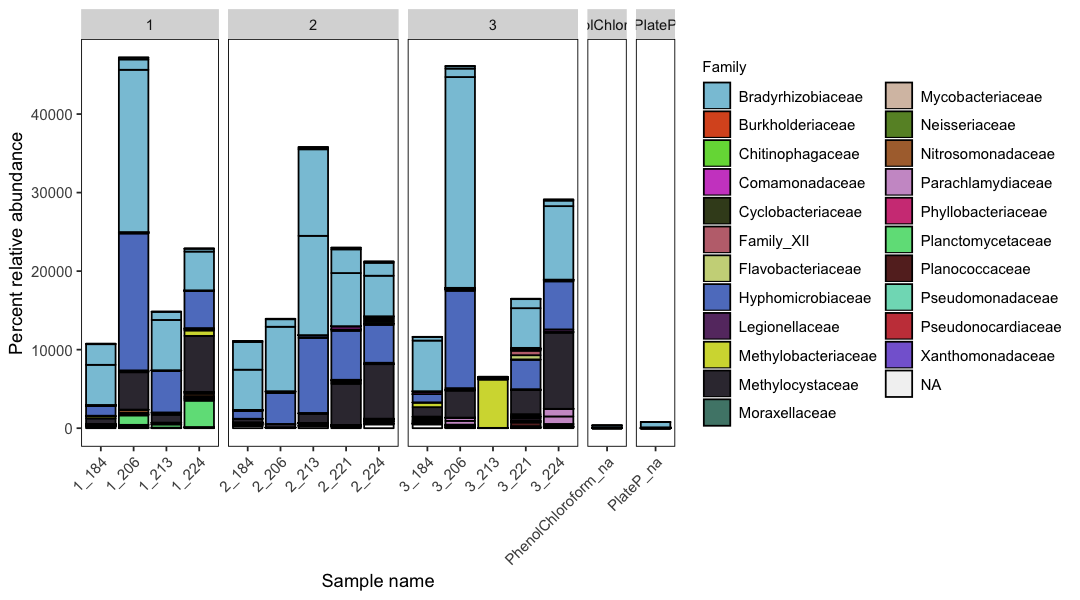

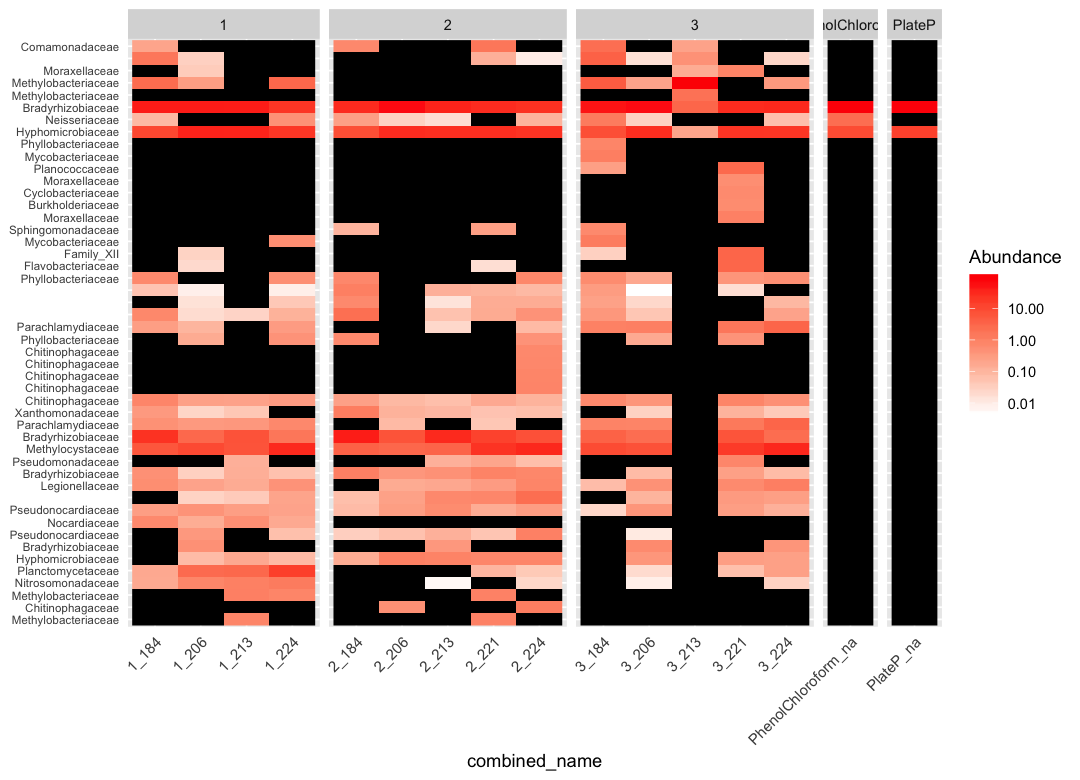

In [38]:
options(repr.plot.width = 9, repr.plot.height = 5)
plot_bar(ps_GAC_blank_reads, x="combined_name", fill="Family") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~Description, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))
                                                                                                 
options(repr.plot.width = 9, repr.plot.height = 6.5)
plot_heatmap(ps_GAC_blank_perc, taxa.label = "Family", sample.label = "combined_name", sample.order = "Name", method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Description, scale="free_x", space="free_x")

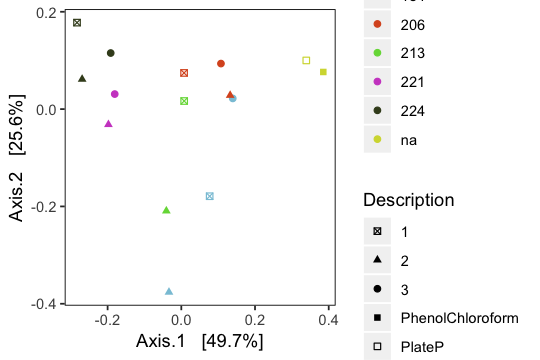

In [39]:
ps_GAC_blank_perc_trim <- subset_samples(ps_GAC_blank_perc, combined_name != "3_213")
GAC.pcoa.bray <- ordinate(ps_GAC_blank_perc_trim, method="PCoA", distance="bray")
options(repr.plot.width = 4.5, repr.plot.height = 3) #for plotting size in jupyter
plot_ordination(ps_GAC_blank_perc, GAC.pcoa.bray, color="Day", shape="Description") + 
    scale_shape_manual(values=c(7,17,19,15, 0, 1))+
    scale_color_manual(values = c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11], colors[12]))+
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))


**SDS Comparisons**

In [40]:
ps_SDS_perc <- subset_samples(ps_bulk_clean_perc, subset= Location %in% "SDS")
ps_blank_sig_perc <- subset_samples(ps_bulk_blank_sig_perc, subset = Type %in% "Blank")
ps_SDS_blank_perc <- merge_phyloseq(ps_SDS_perc, ps_blank_sig_perc)
ps_SDS_blank_perc <- filter_taxa(ps_SDS_blank_perc, filterfun(kOverA(1, 0.5)), TRUE)
ps_SDS_blank_perc

ps_SDS <- subset_samples(ps_bulk_blank_sig, subset= Location %in% "SDS")
ps_blank_sig <- subset_samples(ps_bulk_blank_sig, subset = Type %in% "Blank")
ps_SDS_blank_reads <- merge_phyloseq(ps_SDS, ps_blank_sig)
ps_SDS_blank_reads <- filter_taxa(ps_SDS_blank_reads, filterfun(kOverA(1, 100)), TRUE)
ps_SDS_blank_reads

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 44 taxa and 10 samples ]
sample_data() Sample Data:       [ 10 samples by 29 sample variables ]
tax_table()   Taxonomy Table:    [ 44 taxa by 6 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 41 taxa and 10 samples ]
sample_data() Sample Data:       [ 10 samples by 29 sample variables ]
tax_table()   Taxonomy Table:    [ 41 taxa by 6 taxonomic ranks ]

Warning message:
“Transformation introduced infinite values in discrete y-axis”

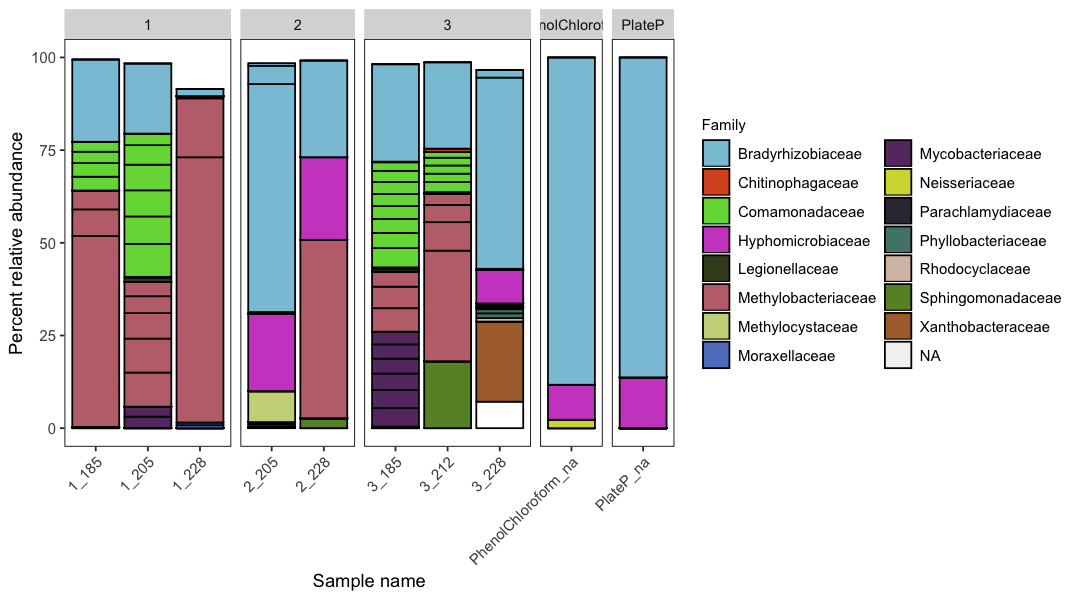

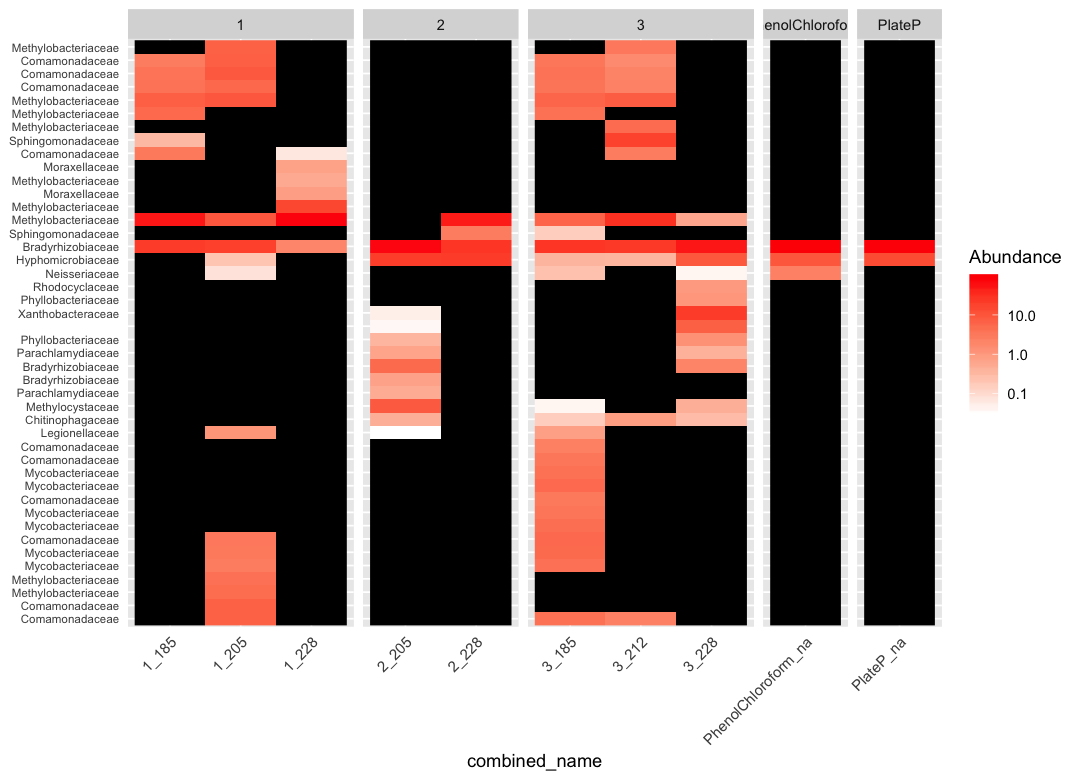

In [41]:
options(repr.plot.width = 9, repr.plot.height = 5)
plot_bar(ps_SDS_blank_perc, x="combined_name", fill="Family") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~Description, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))
                                                                                                 
options(repr.plot.width = 9, repr.plot.height = 6.5)
plot_heatmap(ps_SDS_blank_perc, taxa.label = "Family", sample.label = "combined_name", sample.order = "Name", method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~Description, scale="free_x", space="free_x")

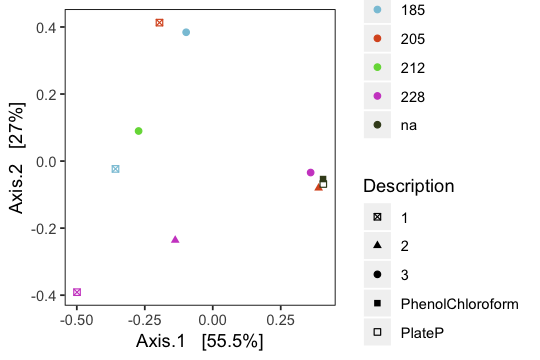

In [42]:
SDS.pcoa.bray <- ordinate(ps_SDS_blank_perc, method="PCoA", distance="bray")
options(repr.plot.width = 4.5, repr.plot.height = 3) #for plotting size in jupyter
plot_ordination(ps_SDS_blank_perc, SDS.pcoa.bray, color="Day", shape="Description") + 
    scale_shape_manual(values=c(7,17,19,15, 0, 1))+
    scale_color_manual(values = c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11], colors[12]))+
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 77 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 29 sample variables ]
tax_table()   Taxonomy Table:    [ 77 taxa by 6 taxonomic ranks ]

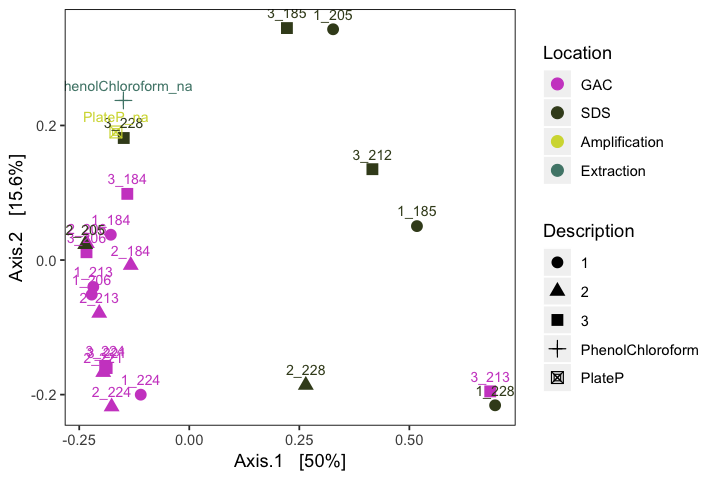

In [43]:
#SDS and GAC together, labeled PCoA

ps_GAC_SDS_perc <- subset_samples(ps_bulk_clean_perc, subset= Location %in% c("GAC", "SDS"))
ps_blank_sig_perc <- subset_samples(ps_bulk_blank_sig_perc, subset = Type %in% "Blank")
ps_GAC_SDS_blank_perc <- merge_phyloseq(ps_GAC_SDS_perc, ps_blank_sig_perc)
ps_GAC_SDS_blank_perc <- filter_taxa(ps_GAC_SDS_blank_perc, filterfun(kOverA(1, 0.5)), TRUE)

ps_GAC_SDS_blank_perc

GAC.SDS.pcoa.bray <- ordinate(ps_GAC_SDS_blank_perc, method="PCoA", distance="bray")
options(repr.plot.width = 6, repr.plot.height = 4)
plot_ordination(ps_GAC_SDS_blank_perc, GAC.SDS.pcoa.bray, color="Location", shape="Description") + 
    geom_point(size=3)+
    geom_text(aes(label=combined_name),hjust=0.5, vjust=-1, size=3, show.legend = FALSE)+
    #scale_shape_manual(values=c(7,17,19,15, 0, 1))+
    scale_color_manual(values = c(colors[4],colors[5],colors[10], colors[12]))+
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
#ggsave('/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/GAC_SDS_blank_PCoA.svg', device='svg', height=4, width=6)

# 6. Potential Opportunistic Pathogens through treatment

In [44]:
#get ranges of flow cytometry (TCC) for each location
fcm_all$Location <- factor(fcm_all$Location, levels=c('WW_2ndary', 'Ozone', 'Chloramine', 'MF_combined', 'MF', 'NF-RO_combined', 'NF-RO', 'GAC', 'SDS'))
#change factor levels to allow NF-RO
tcc_range <- fcm_all %>% group_by(Location) %>% na.omit() %>% summarize(tcc_min = min(TCC_avg_cells_per_mL), tcc_median = median(TCC_avg_cells_per_mL), tcc_max = max(TCC_avg_cells_per_mL))
tcc_range$Location[tcc_range$Location=='NF-RO_combined'] <- 'NF-RO'
tcc_range$Location[tcc_range$Location=='MF_combined'] <- 'MF'
tcc_range

Location,tcc_min,tcc_median,tcc_max
WW_2ndary,6.788000e+06,9735000,70993333.0
Chloramine,2.353333e+06,7558000,57548000.0
MF,1.400000e+03,2740,5893.0
NF-RO,2.100000e+01,119,2780.0
GAC,4.593000e+03,9827,21447.0
SDS,7.333333e+01,5620,143293.3


In [45]:
##Legionella

#get ranges of relative abundances for each location
bulk_pathogen <- subset_taxa(ps_bulk_clean_perc, Genus=="Legionella")
bulk_pathogen <- filter_taxa(bulk_pathogen, filterfun(kOverA(1, 0.05)), TRUE) #remove any really low OTUs potentially from barcode bleed
bulk_pathogen_sum_abund <- data.frame(perc_pathogen = rowSums(otu_table(bulk_pathogen))) #sum all OTUs by sample

id2location <- subset(sample_data(bulk_pathogen), select=c(Location)) #add sample location
bulk_pathogen_sum_abund <- merge(bulk_pathogen_sum_abund, id2location, by=0)
pathogen_abund_range <- bulk_pathogen_sum_abund %>% group_by(Location) %>% summarize(Perc_min = min(perc_pathogen), Perc_median = median(perc_pathogen), Perc_max = max(perc_pathogen))


pathogen_possible <- merge(tcc_range, pathogen_abund_range, by='Location')

#sort by location, make into rownames, then remove
pathogen_possible$Location <- factor(pathogen_possible$Location, levels=c('WW_2ndary', 'Chloramine', 'MF', 'NF-RO', 'GAC', 'SDS'))
pathogen_possible <- pathogen_possible[order(pathogen_possible$Location),]
row.names(pathogen_possible) <- pathogen_possible$Location
pathogen_possible <- subset(pathogen_possible, select=-Location)

#get ranges of absolute abundance
pathogen_possible$min <- pathogen_possible$tcc_min * pathogen_possible$Perc_min / 100
pathogen_possible$median <- pathogen_possible$tcc_median * pathogen_possible$Perc_median / 100
pathogen_possible$max <- pathogen_possible$tcc_max * pathogen_possible$Perc_max / 100

#pathogen_possible <- apply(pathogen_possible, c(1,2), function(x) signif(x, digits = 2))
pathogen_possible <- apply(pathogen_possible, c(1,2), function(x) scientific(x, digits = 2))
                           
#pathogen_possible$TCC_range <- with(pathogen_possible, paste(tcc_min, tcc_median, tcc_max, sep=','))


#pathogen_possible$Location <- factor(pathogen_possible$Location, levels=c('WW_2ndary', 'Chloramine', 'MF', 'NF-RO', 'GAC', 'SDS'))
#pathogen_possible <- pathogen_possible[order(pathogen_possible$Location),]
#row.names(pathogen_possible) <- pathogen_possible$Location
#pathogen_possible <- subset(pathogen_possible, select=-Location)


pathogen_possible
#write.table(pathogen_possible, '/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/legionella_table.txt', sep='\t', quote=FALSE)

,tcc_min,tcc_median,tcc_max,Perc_min,Perc_median,Perc_max,min,median,max
WW_2ndary,6.8e+06,9.7e+06,7.1e+07,0e+00,8.1e-02,5.7e-01,0e+00,7.9e+03,4.1e+05
Chloramine,2.4e+06,7.6e+06,5.8e+07,0e+00,3.5e-02,1.1e-01,0e+00,2.6e+03,6.5e+04
MF,1.4e+03,2.7e+03,5.9e+03,0e+00,0e+00,0e+00,0e+00,0e+00,0e+00
NF-RO,2.1e+01,1.2e+02,2.8e+03,0e+00,1.6e-01,3.2e-01,0e+00,1.9e-01,8.9e+00
GAC,4.6e+03,9.8e+03,2.1e+04,0e+00,3e-01,1.3e+00,0e+00,3e+01,2.7e+02
SDS,7.3e+01,5.6e+03,1.4e+05,0e+00,3.6e-02,1.1e+00,0e+00,2e+00,1.6e+03


In [46]:
##Mycobacterium

#get ranges of relative abundances for each location
bulk_pathogen <- subset_taxa(ps_bulk_clean_perc, Genus=="Mycobacterium")
bulk_pathogen <- filter_taxa(bulk_pathogen, filterfun(kOverA(1, 0.05)), TRUE) #remove any really low OTUs potentially from barcode bleed
bulk_pathogen_sum_abund <- data.frame(perc_pathogen = rowSums(otu_table(bulk_pathogen))) #sum all OTUs by sample

id2location <- subset(sample_data(bulk_pathogen), select=c(Location)) #add sample location
bulk_pathogen_sum_abund <- merge(bulk_pathogen_sum_abund, id2location, by=0)
pathogen_abund_range <- bulk_pathogen_sum_abund %>% group_by(Location) %>% summarize(Perc_min = min(perc_pathogen), Perc_median = median(perc_pathogen), Perc_max = max(perc_pathogen))

#get ranges of absolute abundance
pathogen_possible <- merge(tcc_range, pathogen_abund_range, by='Location')
pathogen_possible$min <- pathogen_possible$tcc_min * pathogen_possible$Perc_min / 100
pathogen_possible$median <- pathogen_possible$tcc_median * pathogen_possible$Perc_median / 100
pathogen_possible$max <- pathogen_possible$tcc_max * pathogen_possible$Perc_max / 100

pathogen_possible$Location <- factor(pathogen_possible$Location, levels=c('WW_2ndary', 'Chloramine', 'MF', 'NF-RO', 'GAC', 'SDS'))

pathogen_possible <- pathogen_possible[order(pathogen_possible$Location),]
row.names(pathogen_possible) <- pathogen_possible$Location
pathogen_possible <- subset(pathogen_possible, select=-Location)

pathogen_possible <- apply(pathogen_possible, c(1,2), function(x) signif(x, digits = 2))
pathogen_possible
#write.table(pathogen_possible, '/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/mycobacterium_table.txt', sep='\t', quote = FALSE)

,tcc_min,tcc_median,tcc_max,Perc_min,Perc_median,Perc_max,min,median,max
WW_2ndary,6800000,9700000,7.1e+07,0.270,0.880,2.30,1.8e+04,8.5e+04,1.7e+06
Chloramine,2400000,7600000,5.8e+07,0.380,1.900,87.00,8.9e+03,1.4e+05,5.0e+07
MF,1400,2700,5.9e+03,68.000,93.000,97.00,9.5e+02,2.5e+03,5.7e+03
NF-RO,21,120,2.8e+03,0.029,0.044,0.06,6.2e-03,5.3e-02,1.7e+00
GAC,4600,9800,2.1e+04,0.000,0.000,2.40,0.0e+00,0.0e+00,5.2e+02
SDS,73,5600,1.4e+05,0.000,0.074,26.00,0.0e+00,4.1e+00,3.7e+04


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7 taxa and 37 samples ]
sample_data() Sample Data:       [ 37 samples by 29 sample variables ]
tax_table()   Taxonomy Table:    [ 7 taxa by 6 taxonomic ranks ]

Warning message:
“Transformation introduced infinite values in discrete y-axis”

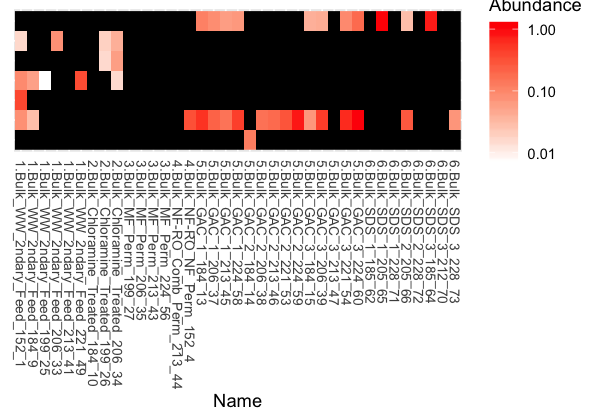

Warning message:
“Removed 60 rows containing missing values (position_stack).”

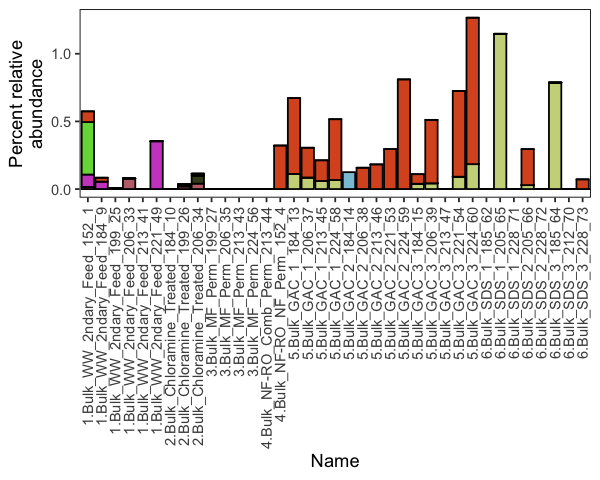

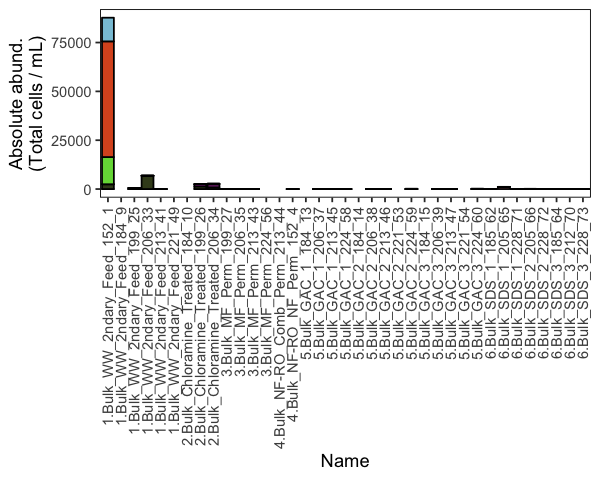

In [47]:
## pathogen plots
bulk_legionella <- subset_taxa(ps_bulk_clean_perc, Genus=="Legionella")
#filter at 0.05% to account for sample bleed
bulk_legionella <- filter_taxa(bulk_legionella, filterfun(kOverA(1, 0.05)), TRUE)
bulk_legionella

#heatmap of all Legionellales ASVs
options(repr.plot.width = 5, repr.plot.height = 3.5)
plot_heatmap(bulk_legionella, taxa.label = "Genus", sample.label = "Name", sample.order = "Name", method=NULL, 
             low="white", high="red", na.value="black", trans = log_trans(10))+
            theme(axis.text.y = element_blank(), axis.title.y = element_blank(), axis.ticks = element_blank())
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/Legionella_heatmap.pdf", device="pdf", width=5, height=3.5)

#relative abundance barplot
options(repr.plot.width = 5, repr.plot.height = 4)
plot_bar(bulk_legionella, x="Name", fill="OTU") + 
    scale_fill_manual(values = colors[1:7]) + 
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5), legend.position="none")+
    ylab("Percent relative\nabundance")
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/Legionella_bar_perc.pdf", device="pdf", width=5, height=4)

### Absolute abundance

bulk_legionella_abs <- bulk_legionella
otu_table(bulk_legionella_abs) <- sample_data(bulk_legionella)$TCC_avg * otu_table(bulk_legionella)/100 #percent -> proportion

#trim dataset to include only samples with cell counts and legionella
bulk_legionella_abs <- filter_taxa(bulk_legionella_abs, filterfun(kOverA(1, 0)), TRUE)

options(repr.plot.width = 5, repr.plot.height = 4)
plot_bar(bulk_legionella_abs, x="Name", fill="OTU") + 
    scale_fill_manual(values = colors[1:7]) + 
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5), legend.position="none")+
    ylab("Absolute abund.\n(Total cells / mL)")
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/Legionella_bar_absolute.pdf", device="pdf", width=5, height=4)

**Mycobacterium species plots:**

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 24 taxa and 37 samples ]
sample_data() Sample Data:       [ 37 samples by 29 sample variables ]
tax_table()   Taxonomy Table:    [ 24 taxa by 6 taxonomic ranks ]

Warning message:
“Transformation introduced infinite values in discrete y-axis”

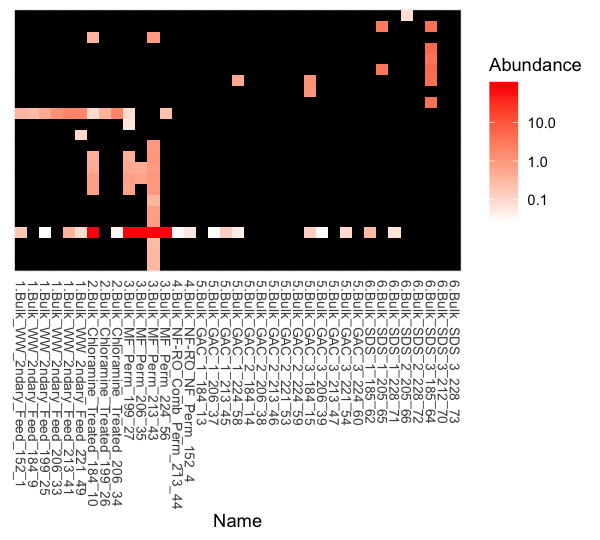

Warning message:
“Removed 220 rows containing missing values (position_stack).”

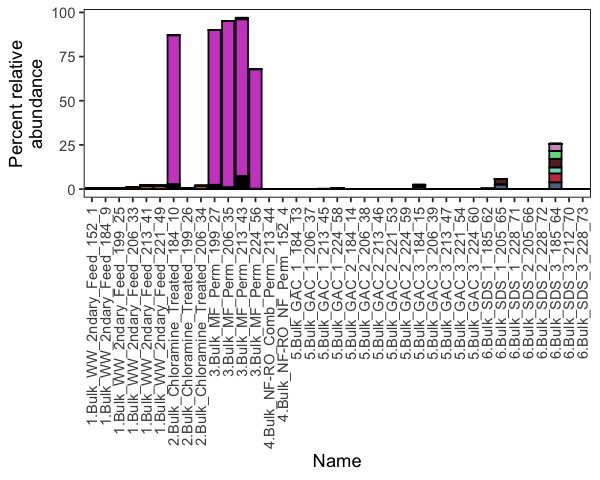

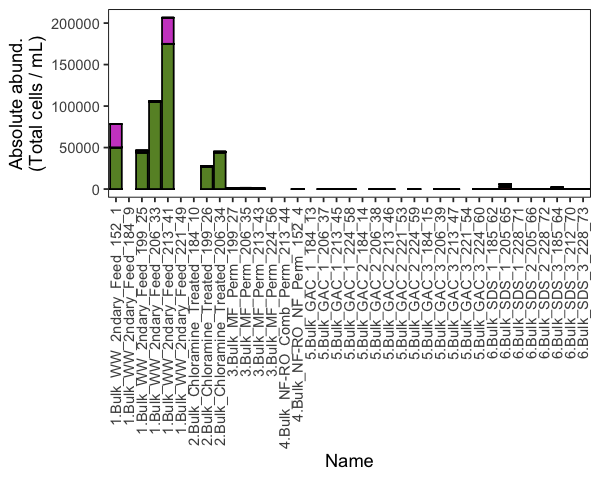

In [48]:
bulk_myco <- subset_taxa(ps_bulk_clean_perc, Genus=="Mycobacterium")
bulk_myco <- filter_taxa(bulk_myco, filterfun(kOverA(1, 0.05)), TRUE)
bulk_myco

#heatmap of all Mycobacterium ASVs
options(repr.plot.width = 5, repr.plot.height = 4.5)
plot_heatmap(bulk_myco, taxa.label = "Genus", sample.label = "Name", sample.order = "Name", method=NULL, 
             low="white", high="red", na.value="black", trans = log_trans(10))+
            theme(axis.text.y = element_blank(), axis.title.y = element_blank(), axis.ticks = element_blank())
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/Mycobacteria_heatmap.pdf", device="pdf", width=5, height=4.5)

#relative abundance barplot
options(repr.plot.width = 5, repr.plot.height = 4)
plot_bar(bulk_myco, x="Name", fill="OTU") + 
    scale_fill_manual(values = colors) + 
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5), legend.position="none")+
    ylab("Percent relative\nabundance")
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/Mycobacteria_bar_perc.pdf", device="pdf", width=5, height=4)

### Absolute abundance

bulk_myco_abs <- bulk_myco
otu_table(bulk_myco_abs) <- sample_data(bulk_myco_abs)$TCC_avg * otu_table(bulk_myco_abs)/100 #percent -> proportion

#trim dataset to include only samples with cell counts and myco
bulk_myco_abs <- filter_taxa(bulk_myco_abs, filterfun(kOverA(1, 0)), TRUE)

options(repr.plot.width = 5, repr.plot.height = 4)
plot_bar(bulk_myco_abs, x="Name", fill="OTU") + 
    scale_fill_manual(values = colors) + 
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5), legend.position="none")+
    ylab("Absolute abund.\n(Total cells / mL)")
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/Mycobacteria_bar_absolute.pdf", device="pdf", width=5, height=4)

# 7. Shared ASVs across treatment processes

In [49]:
#function to identify core community within a location 
get_core_seqs <- function(ps_name, min_abund, min_samples, location){
    location_ids = as.character(get_variable(ps_name, "Location")) == location
    ps_sub <- prune_samples(location_ids, ps_name) #subsample by location
    
    #where number of samples=min_samples, for counts input min_reads-1 (because KOverA uses > not >=)
    core <- filter_taxa(ps_sub, filterfun(kOverA(min_samples, min_abund)), prune=TRUE) 
    return(row.names(tax_table(core))) #core sequences
}

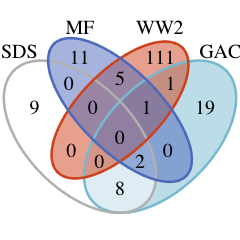

Warning message:
“Transformation introduced infinite values in discrete y-axis”

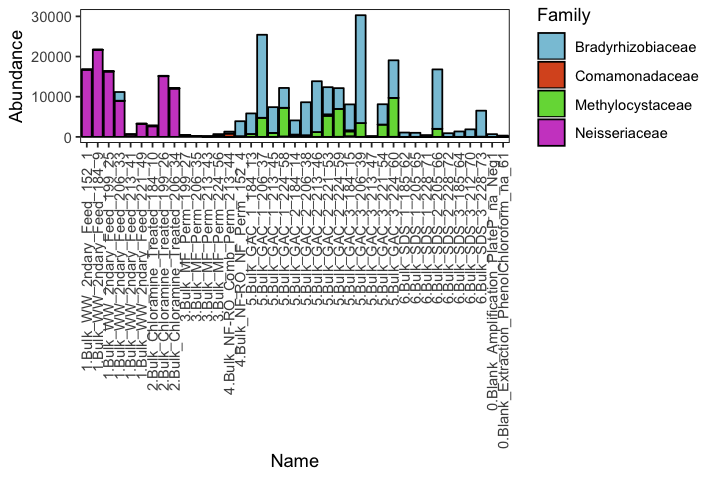

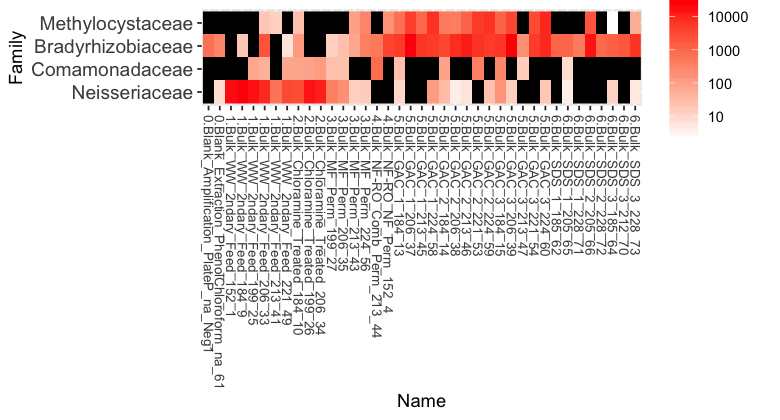

In [50]:
###Figure 4A

min_abund <- 50 #reads #0.05 #percent
min_samples <- 2
#dataset <- ps_bulk_unfiltered
dataset <- ps_bulk_blank_sig

core.WW2 <- get_core_seqs(dataset, min_abund, min_samples, "WW_2ndary") #6 samples
core.MF <- get_core_seqs(dataset, min_abund, min_samples, "MF") #4 samples
core.GAC <- get_core_seqs(dataset, min_abund, min_samples, "GAC") #14 samples: 4 CatalyticReagg, 5 Reagg, 5 Coconut
core.SDS <- get_core_seqs(dataset, min_abund, min_samples, "SDS") #8 samples: 3 CatalyticReagg, 3 Reagg, 2 Coconut

options(repr.plot.width = 2, repr.plot.height = 2)
#pdf("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/venndiagram_50reads_2samp_4way.pdf", width=2, height=2)
cores=list(
    "SDS"=core.SDS,
    "GAC"=core.GAC,
    "MF"=core.MF,
    "WW2"=core.WW2
    )
grid.draw(venn.diagram(cores, NULL, col=c("gray", "#89C5DA", "#5F7FC7", "#DA5724" ), 
                       fill=c("white", "#89C5DA", "#5F7FC7", "#DA5724")))
#dev.off()

#plot intersect
partitions <- get.venn.partitions(cores)
allover_seqs <- partitions[partitions$GAC==TRUE & partitions$WW2==TRUE,]$..values..
allover_seqs <- append(allover_seqs, partitions[partitions$GAC==TRUE & partitions$MF==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$SDS==TRUE & partitions$MF==TRUE,]$..values..)

allover_seqs <- unname(c(unlist(allover_seqs))) #convert to unnamed vector
ps_allover <- prune_taxa(allover_seqs, dataset)

options(repr.plot.width = 6, repr.plot.height = 4)
plot_bar(ps_allover, x="Name", fill="Family") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5))

options(repr.plot.width = 6.5, repr.plot.height = 3.5)
plot_heatmap(ps_allover, taxa.label = "Family", sample.label = "Name", sample.order = "Name", method=NULL,
             low="white", high="red", na.value="black", trans = log_trans(10))

In [51]:
#what are these seqs and how abundant are they? Get otu table, tax table, merge, rename

shared_otus <- as.data.frame(otu_table(ps_allover)) #get otu table
shared_otus <- as.data.frame(t(shared_otus)) #otus as rows
shared_taxa <- as.data.frame(tax_table(ps_allover) [, c("Family","Genus")]) #get tax table
shared_seq_info <- merge(shared_otus, shared_taxa, by=0) #merge otus and tax tables

shared_seq_info$taxonomy <- paste(shared_seq_info$Family, shared_seq_info$Genus, sep="_") #convert tax to family_genus
row.names(shared_seq_info) <- shared_seq_info$taxonomy #make tax as rownames
shared_seq_info <- subset(shared_seq_info, select=c(-Row.names, -Family, -Genus, -taxonomy)) #drop extra columns

shared_seq_info <- t((shared_seq_info)) #transpose so taxa are columns, samples are rows
shared_seq_info <- as.data.frame(shared_seq_info)
names <- subset(sample_data(ps_allover), select=c(Name, filtered_readcounts)) #get sample names for rows
shared_seq_info <- merge(names, shared_seq_info, by=0)
row.names(shared_seq_info) <- shared_seq_info$Name
shared_seq_info <- subset(shared_seq_info, select=c(-Name, -Row.names))
shared_seq_info <- shared_seq_info[order(row.names(shared_seq_info)),] #sort by sample name

shared_seq_info
#write.table(shared_seq_info,'/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/shared_sequences_across_treatment.txt', sep='\t', quote=FALSE)

,filtered_readcounts,Neisseriaceae_NA,Comamonadaceae_Ottowia,Bradyrhizobiaceae_Bradyrhizobium,Methylocystaceae_Methylocystis
0.Blank_Amplification_PlateP_na_Neg1,787,0,0,679,0
0.Blank_Extraction_PhenolChloroform_na_61,350,8,0,309,0
1.Bulk_WW_2ndary_Feed_152_1,68076,16753,0,0,0
1.Bulk_WW_2ndary_Feed_184_9,41718,21689,0,20,0
1.Bulk_WW_2ndary_Feed_199_25,70994,16282,70,0,0
1.Bulk_WW_2ndary_Feed_206_33,26747,8934,48,2168,20
1.Bulk_WW_2ndary_Feed_213_41,8964,597,0,0,13
1.Bulk_WW_2ndary_Feed_221_49,16410,3222,73,6,0
2.Bulk_Chloramine_Treated_184_10,66864,2638,78,124,27
2.Bulk_Chloramine_Treated_199_26,57945,15111,86,0,0


In [52]:
#prepare data for ggplot-style heatmap
shared_seq_info2 <- shared_seq_info

shared_seq_info2$samples <- row.names(shared_seq_info2)
read_counts_only <- subset(shared_seq_info2, select=c(filtered_readcounts, samples))
shared_seq_info2 <- subset(shared_seq_info2, select=-filtered_readcounts)
shared_seq_info_melt <- melt(shared_seq_info2, id.vars='samples', value.name = 'reads', variable.name = 'taxon')
readcounts_melt <- melt(read_counts_only, id.vars='samples', value.name = 'reads', variable.name = 'filtered')

shared_seq_perc <- shared_seq_info

shared_seq_perc <- shared_seq_perc * 100 / shared_seq_perc$filtered_readcounts
shared_seq_perc$samples <- row.names(shared_seq_perc)
shared_seq_perc <- subset(shared_seq_perc, select=-filtered_readcounts)
shared_seq_perc_melt <- melt(shared_seq_perc, id.vars='samples', value.name = 'perc_rel_abund', variable.name = 'taxon')

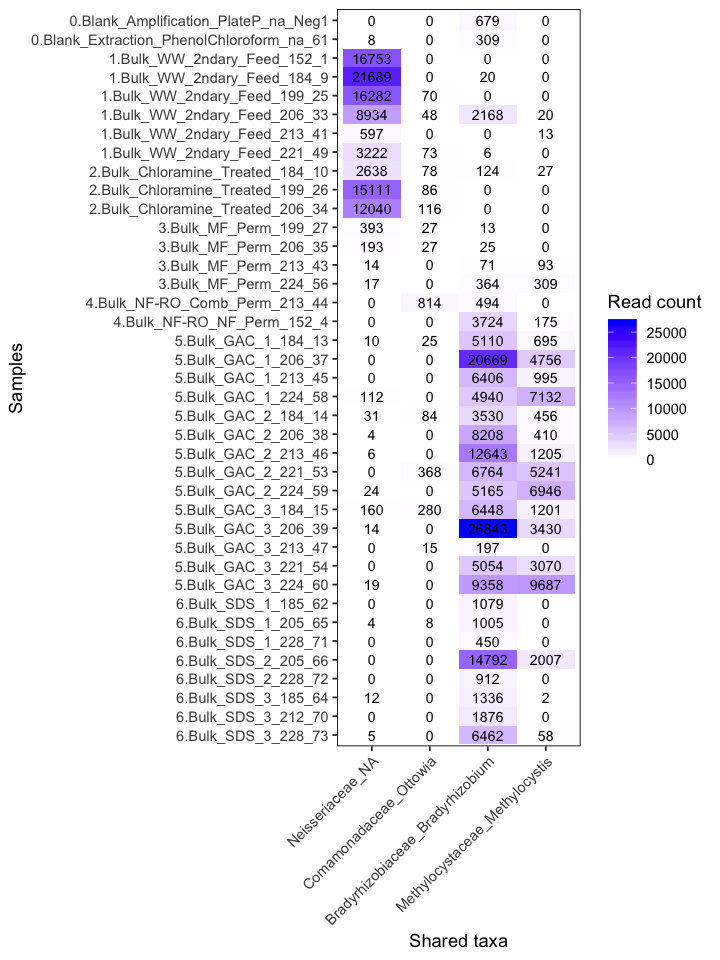

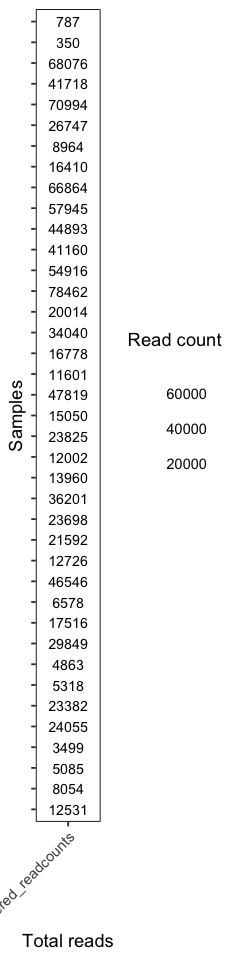

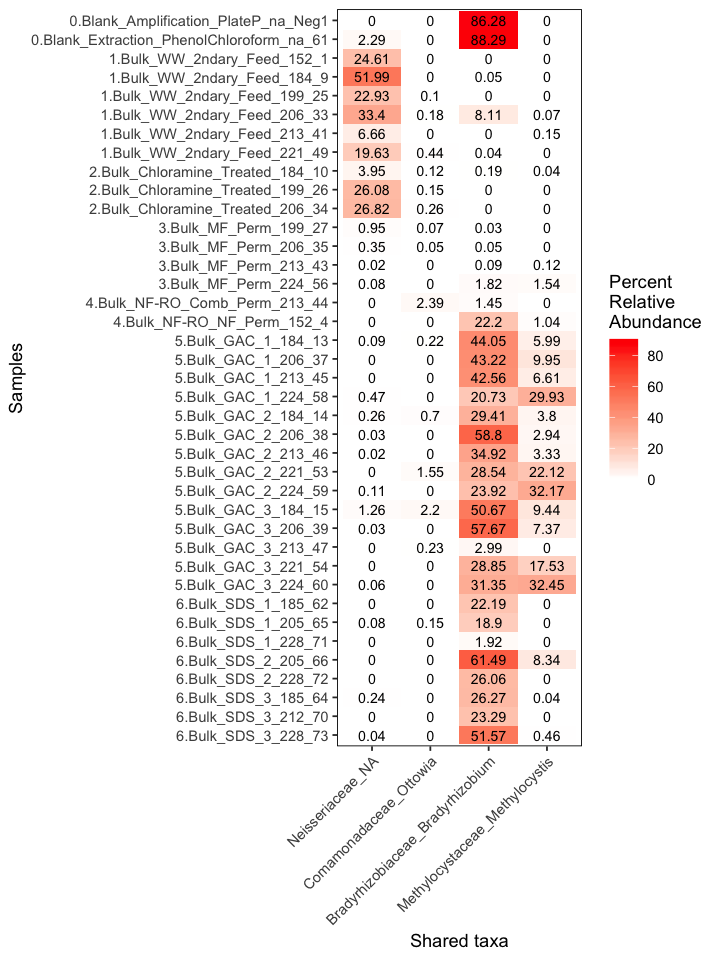

In [53]:
options(repr.plot.width = 6, repr.plot.height = 8)
ggplot(shared_seq_info_melt, aes(taxon, samples)) +
    geom_tile(aes(fill = reads)) + 
    geom_text(aes(label = reads), size=3) +
    scale_y_discrete(limits = rev((shared_seq_info2$samples)))+ #reverse order of y axis
    scale_fill_gradient(low = "white", high = "blue", name="Read count")+
    xlab("Shared taxa")+
    ylab("Samples")+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/shared_text_heatmap_reads.pdf", device="pdf", width=6, height=8)

#plot readcounts as their own column
options(repr.plot.width = 2, repr.plot.height = 8)
ggplot(readcounts_melt, aes(filtered, samples)) +
    geom_tile(aes(fill = reads)) + 
    geom_text(aes(label = reads), size=3) +
    scale_y_discrete(limits = rev((read_counts_only$samples)))+ #reverse order of y axis
    scale_fill_gradient(low = "white", high = "white", name="Read count")+
    xlab("Total reads")+
    ylab("Samples")+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), axis.text.y = element_blank())
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/shared_text_readcounts-only.pdf", device="pdf", width=2, height=7.5)


options(repr.plot.width = 6, repr.plot.height = 8)
ggplot(shared_seq_perc_melt, aes(taxon, samples)) +
    geom_tile(aes(fill = perc_rel_abund)) + 
    geom_text(aes(label = round(perc_rel_abund,2)), size=3) +
    scale_y_discrete(limits = rev((shared_seq_perc$samples)))+ #reverse order of y axis
    scale_fill_gradient(low = "white", high = "red", name="Percent\nRelative\nAbundance")+
    xlab("Shared taxa")+
    ylab("Samples")+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))
#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/shared_text_heatmap_perc.pdf", device="pdf", width=6, height=8)